## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AI

Mounted at /content/drive
/content/drive/MyDrive/AI


In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow import keras as keras


# Set seeds for random number generators in NumPy, Python and Tensor Flow
seed=42
np.random.seed(42)
tf.random.set_seed(42);
tf.compat.v1.set_random_seed(42);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.gridspec as gridspec
import cv2
import keras_cv
from sklearn.utils.class_weight import compute_class_weight
#import nrrd # to open our images
#from cleanvision import Imagelab

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.18.0


## ⏳ Load the Data

In [ ]:
import pickle
tumor_class_clean = np.load('/content/drive/MyDrive/AI/tumor_class_clean.npy')
nodule_clean = np.load('/content/drive/MyDrive/AI/nodule_dataset_clean.npy')

print(f"number of full_slice labels: {len(tumor_class_clean)}")
print(f'number of nodule images: {len(nodule_clean)}')

number of full_slice labels: 2276
number of nodule images: 2276


## 🔧 Prepare dataset

In [ ]:
from sklearn.model_selection import train_test_split

# train - validation split
train_indices, val_indices = train_test_split(
    np.arange(len(nodule_clean)),
    test_size=0.2,
    random_state=42,
    stratify=tumor_class_clean
)

X_train_nodule = nodule_clean[train_indices]
X_val_nodule = nodule_clean[val_indices]
y_train_nodule = tumor_class_clean[train_indices]
y_val_nodule = tumor_class_clean[val_indices]

print("Training Data Shape (nodule):", X_train_nodule.shape)
print("Training Label Shape (nodule):", y_train_nodule.shape)
print("Validation Data Shape (nodule):", X_val_nodule.shape)
print("Validation Label Shape (nodule):", y_val_nodule.shape)

Training Data Shape (nodule): (1820, 64, 64)
Training Label Shape (nodule): (1820,)
Validation Data Shape (nodule): (456, 64, 64)
Validation Label Shape (nodule): (456,)


In [ ]:
#From list to tensor
X_train_nodule = np.asarray(X_train_nodule)
y_train_nodule = np.asarray(y_train_nodule)
X_val_nodule = np.asarray(X_val_nodule)
y_val_nodule = np.asarray(y_val_nodule)


In [ ]:
print(X_train_nodule.shape)
print(y_train_nodule.shape)

(1820, 64, 64)
(1820,)


In [ ]:

# add the extra dimension for the color

X_train_nodule = np.expand_dims(X_train_nodule, axis=-1)
X_val_nodule = np.expand_dims(X_val_nodule, axis=-1)

y_train_nodule = np.expand_dims(y_train_nodule, axis=-1)
y_val_nodule = np.expand_dims(y_val_nodule, axis=-1)


print("nodules:")
print(f"X_train: {X_train_nodule.shape}")
print(f"y_train: {y_train_nodule.shape}")
print(f"X_val: {X_val_nodule.shape}")
print(f"y_val: {y_val_nodule.shape}")


nodules:
X_train: (1820, 64, 64, 1)
y_train: (1820, 1)
X_val: (456, 64, 64, 1)
y_val: (456, 1)


In [ ]:
# check the type
print(X_train_nodule.dtype)
print(y_train_nodule.dtype)

# trasform in tf.float32
X_train_nodule = X_train_nodule.astype(np.float32)
y_train_nodule = y_train_nodule.astype(np.float32)
X_val_nodule = X_val_nodule.astype(np.float32)
y_val_nodule= y_val_nodule.astype(np.float32)

int16
int64


## 🔄 Process Data:

1. Clipping

Valore dei pixel da -2048.0 a -1945.6199951171875: 61 occorrenze
Valore dei pixel da -1945.6199951171875 a -1843.239990234375: 3 occorrenze
Valore dei pixel da -1843.239990234375 a -1740.8599853515625: 1 occorrenze
Valore dei pixel da -1740.8599853515625 a -1638.47998046875: 2 occorrenze
Valore dei pixel da -1638.47998046875 a -1536.0999755859375: 1 occorrenze
Valore dei pixel da -1536.0999755859375 a -1433.719970703125: 0 occorrenze
Valore dei pixel da -1433.719970703125 a -1331.3399658203125: 0 occorrenze
Valore dei pixel da -1331.3399658203125 a -1228.9599609375: 0 occorrenze
Valore dei pixel da -1228.9599609375 a -1126.5799560546875: 29 occorrenze
Valore dei pixel da -1126.5799560546875 a -1024.199951171875: 463 occorrenze
Valore dei pixel da -1024.199951171875 a -921.8200073242188: 704061 occorrenze
Valore dei pixel da -921.8200073242188 a -819.4400024414062: 2813577 occorrenze
Valore dei pixel da -819.4400024414062 a -717.0599975585938: 1218782 occorrenze
Valore dei pixel da -717

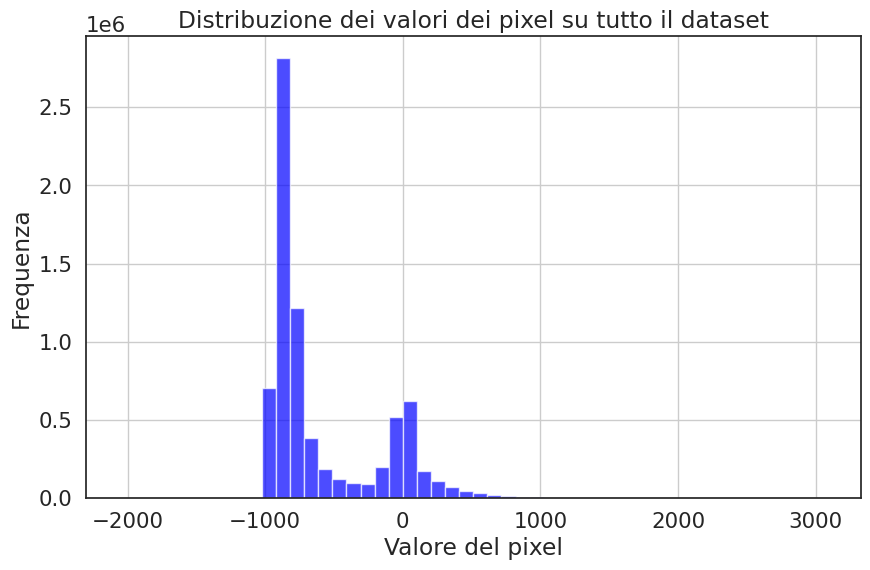

In [ ]:
# NODULE

all_pixels = np.concatenate([img.flatten() for img in X_train_nodule])

# pixel distribution
frequenze, bin_edges = np.histogram(all_pixels, bins=50)

# print results
for i in range(len(frequenze)):
    print(f"Valore dei pixel da {bin_edges[i]} a {bin_edges[i+1]}: {frequenze[i]} occorrenze")

# show histogram
plt.figure(figsize=(10,6))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione dei valori dei pixel su tutto il dataset')
plt.xlabel('Valore del pixel')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

Valore dei pixel da -1000.0 a -972.0: 111846 occorrenze
Valore dei pixel da -972.0 a -944.0: 213075 occorrenze
Valore dei pixel da -944.0 a -916.0: 491490 occorrenze
Valore dei pixel da -916.0 a -888.0: 779755 occorrenze
Valore dei pixel da -888.0 a -860.0: 862486 occorrenze
Valore dei pixel da -860.0 a -832.0: 765015 occorrenze
Valore dei pixel da -832.0 a -804.0: 585129 occorrenze
Valore dei pixel da -804.0 a -776.0: 416594 occorrenze
Valore dei pixel da -776.0 a -748.0: 290185 occorrenze
Valore dei pixel da -748.0 a -720.0: 203353 occorrenze
Valore dei pixel da -720.0 a -692.0: 148425 occorrenze
Valore dei pixel da -692.0 a -664.0: 112448 occorrenze
Valore dei pixel da -664.0 a -636.0: 88106 occorrenze
Valore dei pixel da -636.0 a -608.0: 71237 occorrenze
Valore dei pixel da -608.0 a -580.0: 59398 occorrenze
Valore dei pixel da -580.0 a -552.0: 50937 occorrenze
Valore dei pixel da -552.0 a -524.0: 44566 occorrenze
Valore dei pixel da -524.0 a -496.0: 39165 occorrenze
Valore dei pixe

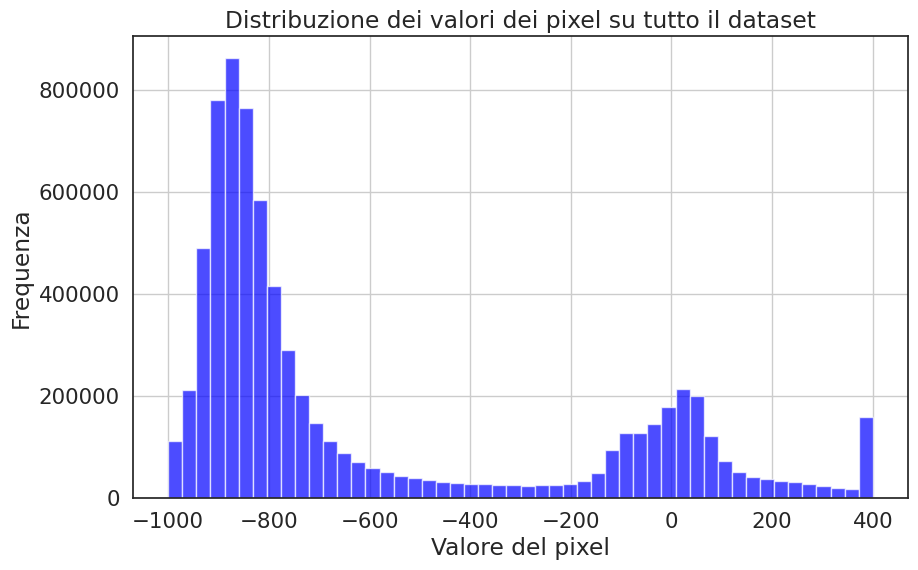

In [ ]:
# clipping
lower_bound = -1000 #-1100
upper_bound = 400 #800

X_train_nodule = [np.clip(img, lower_bound, upper_bound) for img in X_train_nodule]
X_val_nodule= [np.clip(img, lower_bound, upper_bound) for img in X_val_nodule]
all_pixels = np.concatenate([img.flatten() for img in X_train_nodule])

# pixel distribution
frequenze, bin_edges = np.histogram(all_pixels, bins=50)

# print results
for i in range(len(frequenze)):
    print(f"Valore dei pixel da {bin_edges[i]} a {bin_edges[i+1]}: {frequenze[i]} occorrenze")

# show histogram
plt.figure(figsize=(10,6))
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Distribuzione dei valori dei pixel su tutto il dataset')
plt.xlabel('Valore del pixel')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

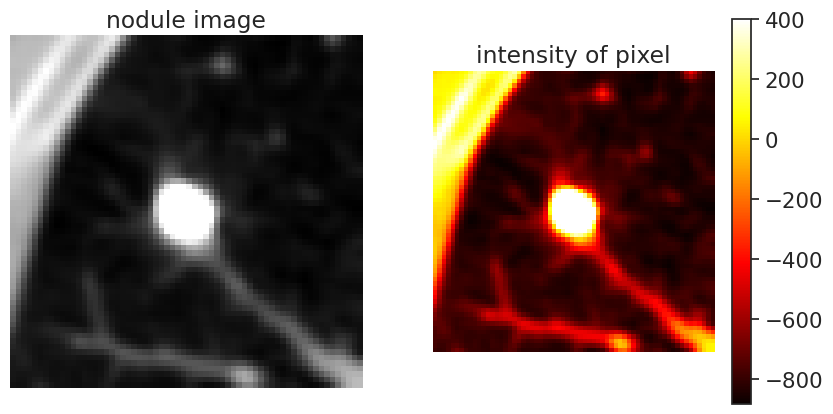

In [ ]:
# just for visual understanding
def show_image_with_intensity(image, title="Image"):
    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    # image with heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='hot')
    plt.title('intensity of pixel')
    plt.colorbar()
    plt.axis('off')

    plt.show()

# show
show_image_with_intensity(X_train_nodule[5], title="nodule image")

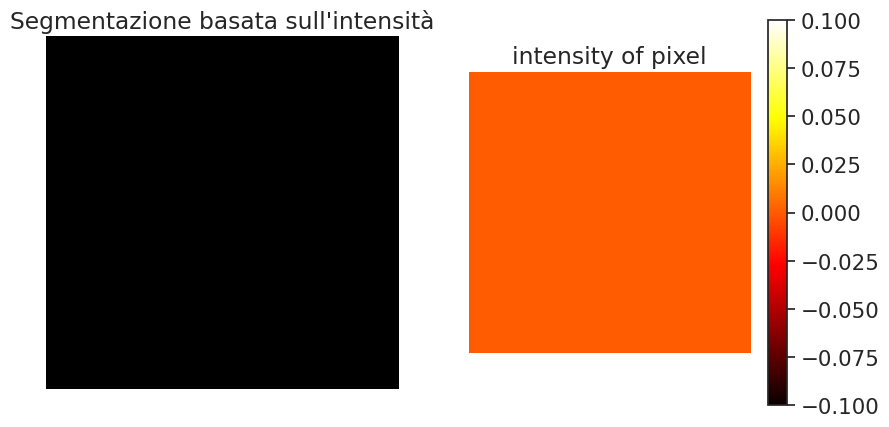

In [ ]:
def segment_by_intensity(image, low_threshold, high_threshold):
# mask to show only pixels btw the 2 thr (low, high)
    mask = (image > low_threshold) & (image < high_threshold)

    # apply mask
    segmented_image = np.zeros_like(image)
    segmented_image[mask] = image[mask]

    return segmented_image

segmented_nodule = segment_by_intensity(X_train_nodule[14], -1000, -900)
show_image_with_intensity(segmented_nodule, title="Segmentazione basata sull'intensità")

Preprocessing completato con CLAHE su X_train_nodule!


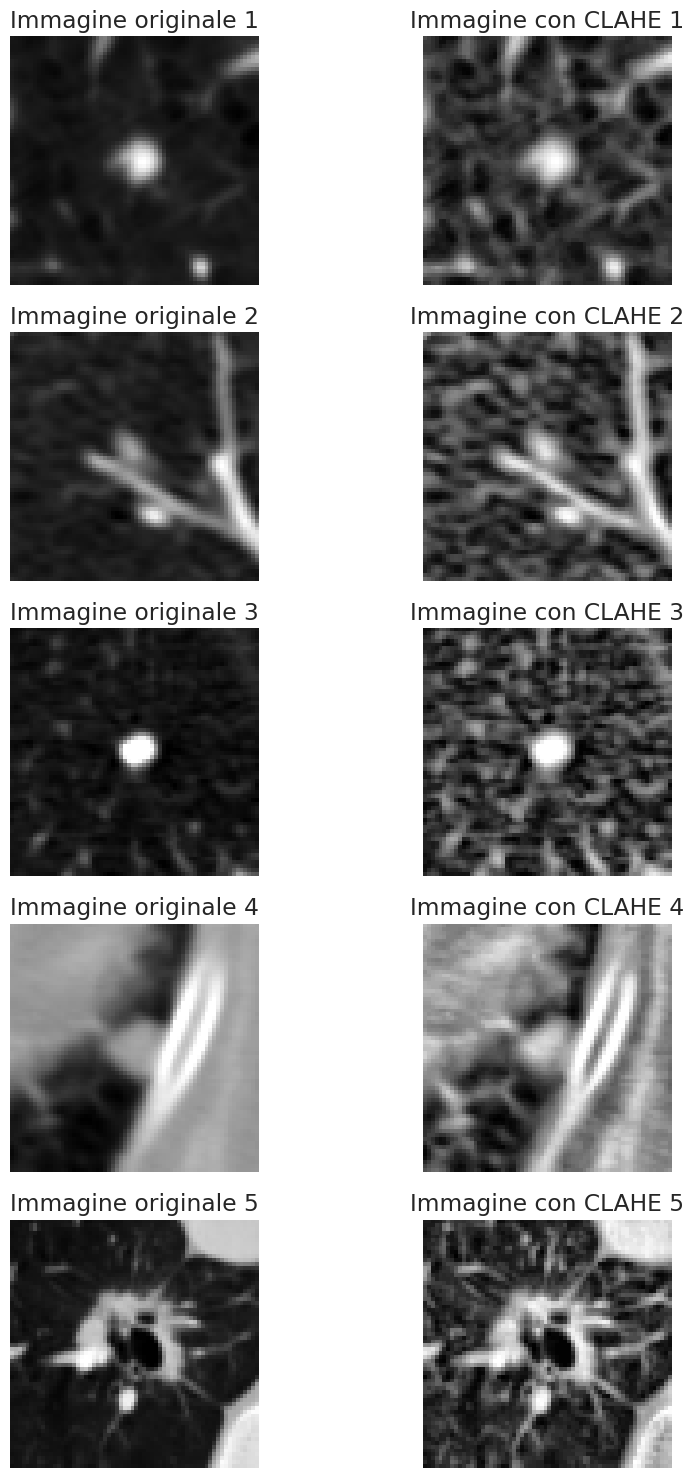

In [ ]:
# CLAHE
def apply_clahe(image):
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# apply Clahe
X_train_nodule_clahe = np.array([apply_clahe(img) for img in X_train_nodule])
X_val_nodule_clahe = np.array([apply_clahe(img) for img in X_val_nodule])

print("Preprocessing completato con CLAHE su X_train_nodule!")

# select 5 random images
n_images = 5
random_indices = np.random.choice(len(X_train_nodule), n_images, replace=False)
sample_images = [X_train_nodule[i] for i in random_indices]
sample_images_clahe = [X_train_nodule_clahe[i] for i in random_indices]


# visualize before/after clahe
fig, axes = plt.subplots(n_images, 2, figsize=(10, 15))

for i in range(n_images):
    # original image
    axes[i, 0].imshow(sample_images[i], cmap='gray')
    axes[i, 0].set_title(f"Immagine originale {i+1}")
    axes[i, 0].axis('off')

    # Clahe image
    axes[i, 1].imshow(sample_images_clahe[i], cmap='gray')
    axes[i, 1].set_title(f"Immagine con CLAHE {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

X_train_nodule=X_train_nodule_clahe
X_val_nodule=X_val_nodule_clahe

Preprocessing completato con denoising su X_train_nodule!


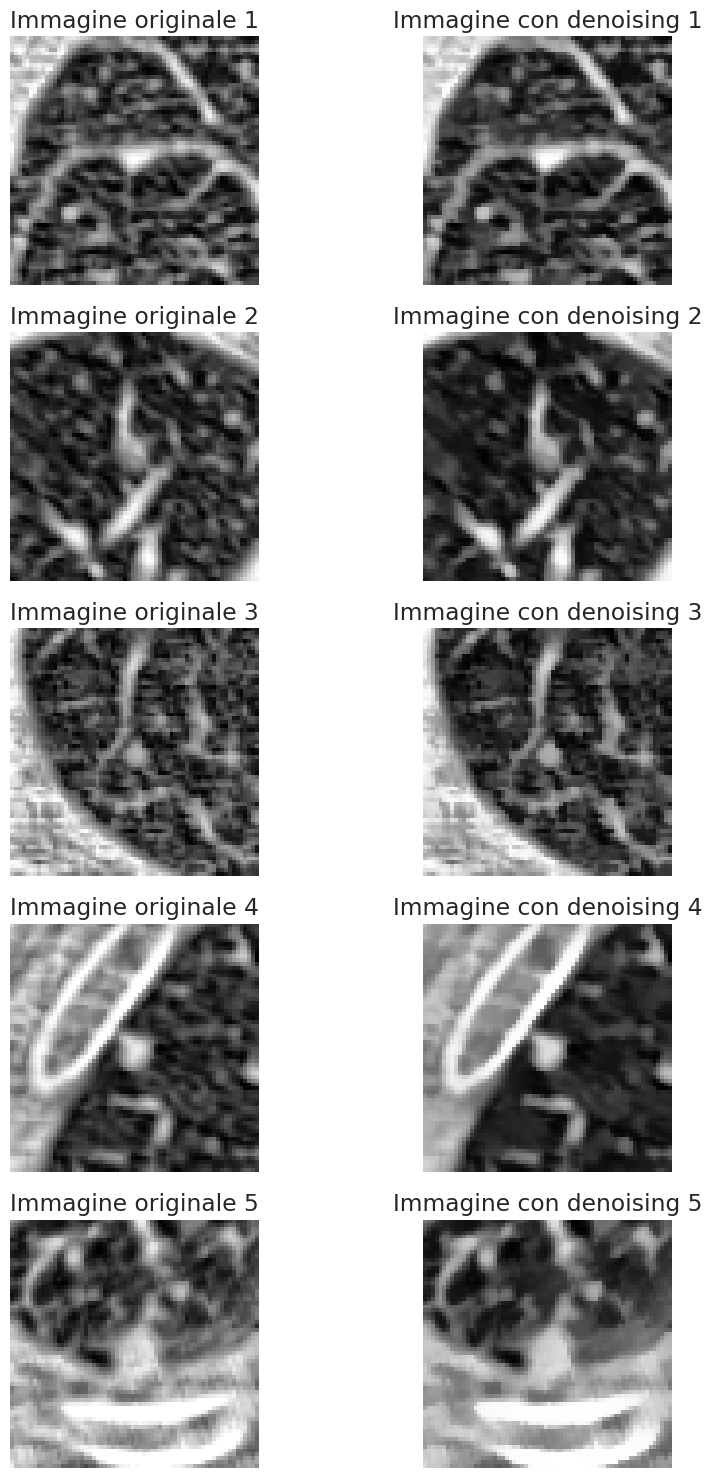

In [ ]:
# Denoising (bilateral filter)
def denoise_image(image):
    return cv2.bilateralFilter(image, d=9, sigmaColor=20, sigmaSpace=20)

X_train_nodule_den = np.array([denoise_image(img) for img in X_train_nodule])
X_val_nodule_den = np.array([denoise_image(img) for img in X_val_nodule])

print("Preprocessing completato con denoising su X_train_nodule!")

# select 5 random image
n_images = 5
random_indices = np.random.choice(len(X_train_nodule), n_images, replace=False)
sample_images = [X_train_nodule[i] for i in random_indices]
sample_images_den = [X_train_nodule_den[i] for i in random_indices]

# visualize before/after
fig, axes = plt.subplots(n_images, 2, figsize=(10, 15))

for i in range(n_images):
    # original image
    axes[i, 0].imshow(sample_images[i], cmap='gray')
    axes[i, 0].set_title(f"Immagine originale {i+1}")
    axes[i, 0].axis('off')

    # CLAHE image
    axes[i, 1].imshow(sample_images_den[i], cmap='gray')
    axes[i, 1].set_title(f"Immagine con denoising {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

X_train_nodule=X_train_nodule_den
X_val_nodule=X_val_nodule_den

Normalization

In [ ]:
# check max and min pixel value
min_nodule = np.min(X_train_nodule)
max_nodule = np.max(X_train_nodule)

print(f"max di nodule: {max_nodule}")
print(f"min di nodule: {min_nodule}")

max di nodule: 255
min di nodule: 8


In [ ]:
# Normalization
X_train_nodule = ((X_train_nodule - min_nodule) / (max_nodule - min_nodule)) #*255
X_val_nodule = ((X_val_nodule - min_nodule) / (max_nodule - min_nodule)) #*255

min_nodule = np.min(X_train_nodule)
max_nodule = np.max(X_train_nodule)

print(f"max di nodule: {max_nodule}")
print(f"min di nodule: {min_nodule}")

max di nodule: 1.0
min di nodule: 0.0


In [ ]:
# rescale pixels around 0
nodule_mean_pixel = np.mean(X_train_nodule)
X_train_nodule = X_train_nodule - nodule_mean_pixel
X_val_nodule = X_val_nodule - nodule_mean_pixel

# Check
min_nodule = np.min(X_train_nodule)
max_nodule = np.max(X_train_nodule)
print(f"max di nodule: {max_nodule}")
print(f"min di nodule: {min_nodule}")

max di nodule: 0.6363572758924398
min di nodule: -0.36364272410756016


class distribution and class weights

number of samples for each class: 
{1.0: 188, 2.0: 355, 3.0: 838, 4.0: 321, 5.0: 118}


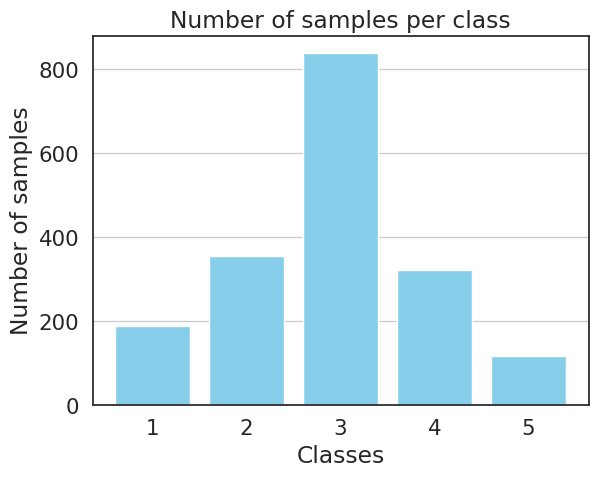

class weights nodule: {0: 1.9361702127659575, 1: 1.0253521126760563, 2: 0.4343675417661098, 3: 1.1339563862928348, 4: 3.0847457627118646}


In [ ]:
unique, counts = np.unique(y_train_nodule, return_counts=True)
print("number of samples for each class: ")
print(dict(zip(unique, counts)))

# show
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

# CLASS WEIGHTS
class_weights_nodule = compute_class_weight('balanced', classes=np.unique(y_train_nodule[:,0]), y=y_train_nodule[:,0])
class_weights_nodule = dict(enumerate(class_weights_nodule))
print("class weights nodule:", class_weights_nodule)

In [ ]:
#1. binary classes

# Convert labels to binary
# (are already btw 0 and 4 => 0,1,2 benign ; 3-4 malign
y_train_nodule_bin = np.where(y_train_nodule < 3, 0, 1)
y_val_nodule_bin = np.where(y_val_nodule <3, 0, 1)


number of samples for each class: 
{0: 543, 1: 1277}


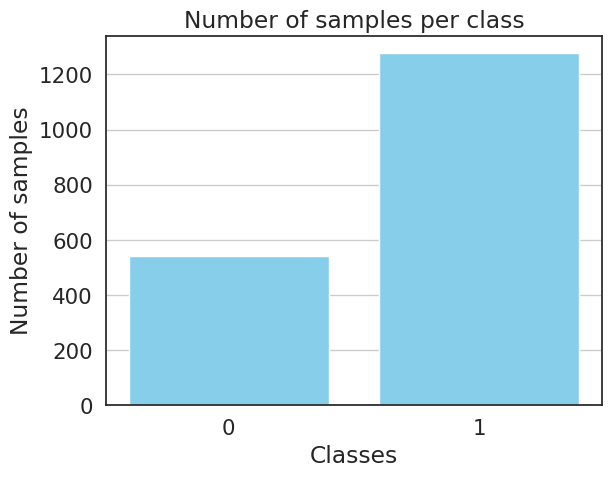

class weights nodule: {0: 1.6758747697974217, 1: 0.7126076742364917}


In [ ]:
# Binary distribution and class weights
unique, counts = np.unique(y_train_nodule_bin, return_counts=True)
print("number of samples for each class: ")
print(dict(zip(unique, counts)))

# show
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(unique)
plt.grid(axis='y')
plt.show()

# CLASS WEIGHTS
weights_nodule_bin = compute_class_weight('balanced', classes=np.unique(y_train_nodule_bin[:,0]), y=y_train_nodule_bin[:,0])
weights_nodule_bin = dict(enumerate(weights_nodule_bin))
print("class weights nodule:", weights_nodule_bin)


one-hot encoding

In [ ]:
# Convert labels to categorical format using one-hot encoding
# in one-hot the index start from 0 => i have to convert into from 0 to 4 in order to have 5 classes

y_train_nodule = tfk.utils.to_categorical(y_train_nodule - 1)
y_val_nodule = tfk.utils.to_categorical(y_val_nodule - 1)

print(y_val_nodule.shape)

y_train_nodule_bin=tfk.utils.to_categorical(y_train_nodule_bin)
y_val_nodule_bin=tfk.utils.to_categorical(y_val_nodule_bin)
# ok, 5 classes (0-4 which corrispond to the real classes 1-5) => at the end I have to make +1 to the predictions

(456, 5)


## ☢️ Radiomic Features

To extract radiomic features we used the Pyradiomic Python library

In [ ]:
pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.

In [ ]:
from radiomics import featureextractor  # PyRadiomics
import SimpleITK as sitk  # Necessario per PyRadiomics

In [ ]:
# Feature extraction on the training set
'''
# Inizializza il feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Configura le feature che vuoi estrarre (puoi personalizzare queste impostazioni)
extractor.enableImageTypes(Wavelet={})#Original={}, LoG={}, Wavelet={})

# Lista per salvare le feature estratte
features_train = []

# Cicla sulle tue immagini di addestramento (X_train_nodule)
for i, image in enumerate(X_train_nodule):
    print(f"image: {i}")
    # Le immagini devono essere convertite in un formato compatibile con PyRadiomics (SimpleITK image)
    # Le immagini nel tuo array numpy sono già in formato 64x64, quindi le convertiamo direttamente in SimpleITK
    sitk_image = sitk.GetImageFromArray(image)

    # Non usiamo una maschera per ora, quindi la settiamo a None
    #mask = None
    mask_array = np.ones(image.shape)
    mask_array[0, :] = 0  # Bordo superiore
    mask_array[-1, :] = 0  # Bordo inferiore
    mask_array[:, 0] = 0  # Bordo sinistro
    mask_array[:, -1] = 0  # Bordo destro
    mask = sitk.GetImageFromArray(mask_array)

    # Estrai le feature dall'immagine
    try:
        features = extractor.execute(sitk_image, mask)
        #features['image_index'] = i  # Aggiungi l'indice dell'immagine per riferimento
        features_train.append(features)  # Aggiungi il risultato alla lista
    except Exception as e:
        print(f"Errore con l'immagine {i}: {e}")

# Converti la lista di dizionari in un DataFrame Pandas
features_df_train = pd.DataFrame(features_train)

# Salva le feature in un file CSV (opzionale) per analisi successive
features_df_train.to_csv('nodule_features_train_cropped.csv', index=False)

print(f"Feature estratte per {len(features_df_train)} immagini di addestramento.")
'''

In [ ]:
# Feature extraction on the validation set
'''
# Inizializza il feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Configura le feature che vuoi estrarre (puoi personalizzare queste impostazioni)
extractor.enableImageTypes(Wavelet={}) #Original={}, LoG={}, Wavelet={})

# Lista per salvare le feature estratte
features_val = []

# Cicla sulle tue immagini di addestramento (X_train_nodule)
for i, image in enumerate(X_val_nodule):

    # Le immagini devono essere convertite in un formato compatibile con PyRadiomics (SimpleITK image)
    # Le immagini nel tuo array numpy sono già in formato 64x64, quindi le convertiamo direttamente in SimpleITK
    sitk_image = sitk.GetImageFromArray(image)

    # Non usiamo una maschera per ora, quindi la settiamo a None
    #mask = None
    mask_array = np.ones(image.shape)
    mask_array[0, :] = 0  # Bordo superiore
    mask_array[-1, :] = 0  # Bordo inferiore
    mask_array[:, 0] = 0  # Bordo sinistro
    mask_array[:, -1] = 0  # Bordo destro
    mask = sitk.GetImageFromArray(mask_array)
    print(f"Forma dell'immagine: {image.shape}")
    print(f"Forma della maschera: {mask_array.shape}")
    unique_values = np.unique(mask_array)
    print(f"Valori unici nella maschera: {unique_values}")

    # Estrai le feature dall'immagine
    try:
        features = extractor.execute(sitk_image, mask)
        #features['image_index'] = i  # Aggiungi l'indice dell'immagine per riferimento
        features_val.append(features)  # Aggiungi il risultato alla lista
    except Exception as e:
        print(f"Errore con l'immagine {i}: {e}")

# Converti la lista di dizionari in un DataFrame Pandas
features_df_val = pd.DataFrame(features_val)

# Salva le feature in un file CSV (opzionale) per analisi successive
features_df_val.to_csv('nodule_features_val_cropped.csv', index=False)

print(f"Feature estratte per {len(features_df_val)} immagini di validation")
'''

In [ ]:
#features_train= pd.read_csv('/kaggle/input/d/lmoiana/features-train/nodule_features_train.csv')
features_train=pd.read_csv('/kaggle/input/nodule-feature-train/nodule_features_train_cropped.csv')
features_train

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                              v3.0.1                     1.26.4   
1                              v3.0.1                     1.26.4   
2                              v3.0.1                     1.26.4   
3                              v3.0.1                     1.26.4   
4                              v3.0.1                     1.26.4   
...                               ...                        ...   
1815                           v3.0.1                     1.26.4   
1816                           v3.0.1                     1.26.4   
1817                           v3.0.1                     1.26.4   
1818                           v3.0.1                     1.26.4   
1819                           v3.0.1                     1.26.4   

     diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                             2.4.0                          1.8.0   
1                             2.4.0                          1.8.0   
2                             2.4.0                          1.8.0   
3                             2.4.0                          1.8.0   
4                             2.4.0                          1.8.0   
...                             ...                            ...   
1815                          2.4.0                          1.8.0   
1816                          2.4.0                          1.8.0   
1817                          2.4.0                          1.8.0   
1818                          2.4.0                          1.8.0   
1819                          2.4.0                          1.8.0   

     diagnostics_Versions_Python  \
0                        3.10.12   
1                        3.10.12   
2                        3.10.12   
3                        3.10.12   
4                        3.10.12   
...                          ...   
1815                     3.10.12   
1816                     3.10.12   
1817                     3.10.12   
1818                     3.10.12   
1819                     3.10.12   

                     diagnostics_Configuration_Settings  \
0     {'minimumROIDimensions': 2, 'minimumROISize': ...   
1     {'minimumROIDimensions': 2, 'minimumROISize': ...   
2     {'minimumROIDimensions': 2, 'minimumROISize': ...   
3     {'minimumROIDimensions': 2, 'minimumROISize': ...   
4     {'minimumROIDimensions': 2, 'minimumROISize': ...   
...                                                 ...   
1815  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1816  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1817  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1818  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1819  {'minimumROIDimensions': 2, 'minimumROISize': ...   

     diagnostics_Configuration_EnabledImageTypes  \
0                {'Original': {}, 'Wavelet': {}}   
1                {'Original': {}, 'Wavelet': {}}   
2                {'Original': {}, 'Wavelet': {}}   
3                {'Original': {}, 'Wavelet': {}}   
4                {'Original': {}, 'Wavelet': {}}   
...                                          ...   
1815             {'Original': {}, 'Wavelet': {}}   
1816             {'Original': {}, 'Wavelet': {}}   
1817             {'Original': {}, 'Wavelet': {}}   
1818             {'Original': {}, 'Wavelet': {}}   
1819             {'Original': {}, 'Wavelet': {}}   

               diagnostics_Image-original_Hash  \
0     c83fbd43d602bf549bb1d1dd45d990a407be0ca0   
1     31a8fce38fcb6ca142de5a38d701a07fa9e78888   
2     d3ff66315ff450f113203831f3ec35fa003b994c   
3     e1bfad7101f1623e2d02a5f27d10fe8c64070fce   
4     5a33bfa0cdef6fd0afb0ba5190a7138422e94649   
...                                        ...   
1815  276b6039e3aa184b7b59aea1069603658223c7f3   
1816  7dbd67121cbb0cc6150f8f44539c610968f9d140   
1817  713eaab466dd26a0e41524eefc8da1788b466d44   
1818  1c1d23fdf8c10e8966d44a2d47915fe83fdc6046   
1819  0e076e8d40011f468716772d

In [ ]:
#features_val= pd.read_csv('/kaggle/input/features-val/nodule_features_val.csv')
features_val = pd.read_csv('/kaggle/input/noduel-feature-val/nodule_features_val_cropped.csv')
features_val

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                             v3.0.1                     1.26.4   
1                             v3.0.1                     1.26.4   
2                             v3.0.1                     1.26.4   
3                             v3.0.1                     1.26.4   
4                             v3.0.1                     1.26.4   
..                               ...                        ...   
451                           v3.0.1                     1.26.4   
452                           v3.0.1                     1.26.4   
453                           v3.0.1                     1.26.4   
454                           v3.0.1                     1.26.4   
455                           v3.0.1                     1.26.4   

    diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                            2.4.0                          1.8.0   
1                            2.4.0                          1.8.0   
2                            2.4.0                          1.8.0   
3                            2.4.0                          1.8.0   
4                            2.4.0                          1.8.0   
..                             ...                            ...   
451                          2.4.0                          1.8.0   
452                          2.4.0                          1.8.0   
453                          2.4.0                          1.8.0   
454                          2.4.0                          1.8.0   
455                          2.4.0                          1.8.0   

    diagnostics_Versions_Python  \
0                       3.10.12   
1                       3.10.12   
2                       3.10.12   
3                       3.10.12   
4                       3.10.12   
..                          ...   
451                     3.10.12   
452                     3.10.12   
453                     3.10.12   
454                     3.10.12   
455                     3.10.12   

                    diagnostics_Configuration_Settings  \
0    {'minimumROIDimensions': 2, 'minimumROISize': ...   
1    {'minimumROIDimensions': 2, 'minimumROISize': ...   
2    {'minimumROIDimensions': 2, 'minimumROISize': ...   
3    {'minimumROIDimensions': 2, 'minimumROISize': ...   
4    {'minimumROIDimensions': 2, 'minimumROISize': ...   
..                                                 ...   
451  {'minimumROIDimensions': 2, 'minimumROISize': ...   
452  {'minimumROIDimensions': 2, 'minimumROISize': ...   
453  {'minimumROIDimensions': 2, 'minimumROISize': ...   
454  {'minimumROIDimensions': 2, 'minimumROISize': ...   
455  {'minimumROIDimensions': 2, 'minimumROISize': ...   

    diagnostics_Configuration_EnabledImageTypes  \
0               {'Original': {}, 'Wavelet': {}}   
1               {'Original': {}, 'Wavelet': {}}   
2               {'Original': {}, 'Wavelet': {}}   
3               {'Original': {}, 'Wavelet': {}}   
4               {'Original': {}, 'Wavelet': {}}   
..                                          ...   
451             {'Original': {}, 'Wavelet': {}}   
452             {'Original': {}, 'Wavelet': {}}   
453             {'Original': {}, 'Wavelet': {}}   
454             {'Original': {}, 'Wavelet': {}}   
455             {'Original': {}, 'Wavelet': {}}   

              diagnostics_Image-original_Hash  \
0    8a45d3cf3954d1d8e17f3fda5b68a3bbc282f2a2   
1    bc98b20f552b5bca0f0620a132c481bf7a76d3fd   
2    02a5c12cc3bc78bcc496cea51bbfbfcd8f651d86   
3    5b07241feacd65ac928dda3ee302b41255615215   
4    90306472ca6ae50ece5e32253f343f8ad8c00782   
..                                        ...   
451  408b11ea9e81b19b27ecbbbe8dcf70034243b236   
452  484e085ae44a34dc89fed2ed6d8e9ca71a907354   
453  30164ce9079e182b7767f882429b387cef53287b   
454  f2304fe40debfb273fa9c077a55ba79a9ffa4492   
455  6a1ddb888d9521502ec92ece8b8afa0772106e9a   

    diagnostics_Image-original_Dimensionality  \
0

### ⚙️ pre-processing

1. Nan

In [ ]:
# NAN
# train
nan_count = features_train.isna().sum()
columns_with_nan = nan_count[nan_count > 0]
print(columns_with_nan)

# validation
nan_count = features_val.isna().sum()
columns_with_nan = nan_count[nan_count > 0]
print(columns_with_nan)

# no NaN

Series([], dtype: int64)
Series([], dtype: int64)


2. Constast columns

In [ ]:
unique_values_count = features_train.nunique()
columns_with_same_value = unique_values_count[unique_values_count == 1]
print(columns_with_same_value)

columns_to_remove = columns_with_same_value.index

# remove columns
features_train_cleaned = features_train.drop(columns=columns_to_remove) # training
features_val_cleaned = features_val.drop(columns=columns_to_remove)     # validation

# just to check
print(f"train after removing: {features_train_cleaned.shape}")
print(f"val after removing: {features_val_cleaned.shape}")

diagnostics_Versions_PyRadiomics                   1
diagnostics_Versions_Numpy                         1
diagnostics_Versions_SimpleITK                     1
diagnostics_Versions_PyWavelet                     1
diagnostics_Versions_Python                        1
diagnostics_Configuration_Settings                 1
diagnostics_Configuration_EnabledImageTypes        1
diagnostics_Image-original_Dimensionality          1
diagnostics_Image-original_Spacing                 1
diagnostics_Mask-original_Spacing                  1
diagnostics_Mask-original_VolumeNum                1
original_firstorder_Entropy                        1
original_firstorder_Uniformity                     1
original_glcm_Autocorrelation                      1
original_glcm_ClusterProminence                    1
original_glcm_ClusterShade                         1
original_glcm_ClusterTendency                      1
original_glcm_Contrast                             1
original_glcm_Correlation                     

3. non numerical columns

In [ ]:
categorical_columns = features_train_cleaned.select_dtypes(include=['object', 'category']).columns
print("Colonne categoriali o stringhe:", categorical_columns)
print(features_train_cleaned[categorical_columns])
features_train_cleaned = features_train_cleaned.drop(categorical_columns, axis=1) # training
features_val_cleaned = features_val_cleaned.drop(categorical_columns, axis=1)     # validation
# this columns are: an identifier, coordinates of the center, original size, ... (=> useless)
# => I can remove them

Colonne categoriali o stringhe: Index(['diagnostics_Image-original_Hash', 'diagnostics_Image-original_Size',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass'],
      dtype='object')
               diagnostics_Image-original_Hash  \
0     c83fbd43d602bf549bb1d1dd45d990a407be0ca0   
1     31a8fce38fcb6ca142de5a38d701a07fa9e78888   
2     d3ff66315ff450f113203831f3ec35fa003b994c   
3     e1bfad7101f1623e2d02a5f27d10fe8c64070fce   
4     5a33bfa0cdef6fd0afb0ba5190a7138422e94649   
...                                        ...   
1815  276b6039e3aa184b7b59aea1069603658223c7f3   
1816  7dbd67121cbb0cc6150f8f44539c610968f9d140   
1817  713eaab466dd26a0e41524eefc8da1788b466d44   
1818  1c1d23fdf8c10e8966d44a2d47915fe83fdc6046   
1819  0e076e8d40011f468716772d30dd3390910acdf9   

     diagnostics_Image-original_Size  \
0

4. Low-variance features

In [ ]:
threshold = 0.02  # variance thr
variances = features_train_cleaned.var()
relevant_columns = variances[variances > threshold].index

features_train_cleaned = features_train_cleaned[relevant_columns] # training
features_val_cleaned = features_val_cleaned[relevant_columns]     # validation
features_train_cleaned

diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                               1.000000                                2070   
1                               1.000000                                1369   
2                               0.601053                                1260   
3                               0.830000                                1295   
4                               0.637895                                1332   
...                                  ...                                 ...   
1815                            0.922632                                1122   
1816                            1.000000                                 992   
1817                            0.877368                                1680   
1818                            1.000000                                1521   
1819                            0.615263                                1989   

      original_firstorder_90Percentile  original_firstorder_Energy  \
0                             0.617947                  360.470270   
1                             0.606316                  229.796877   
2                             0.299000                   50.842909   
3                             0.652421                  230.000963   
4                             0.242000                   35.149837   
...                                ...                         ...   
1815                          0.750684                  192.114905   
1816                          0.724158                  191.401958   
1817                          0.455842                   94.049506   
1818                          0.311579                   94.414706   
1819                          0.493789                  136.247627   

      original_firstorder_InterquartileRange  original_firstorder_Kurtosis  \
0                                   0.416316                      2.308831   
1                                   0.436842                      2.549392   
2                                   0.038947                      8.031312   
3                                   0.490000                      1.327524   
4                                   0.065789                      9.607093   
...                                      ...                           ...   
1815                                0.399342                      2.323073   
1816                                0.501447                      1.973515   
1817                                0.053158                      6.594211   
1818                                0.054737                     15.335592   
1819                                0.108421                      3.690398   

      original_firstorder_Maximum  original_firstorder_Range  \
0                        1.000000                   0.960000   
1                        1.000000                   0.947368   
2                        0.600526                   0.540526   
3                        0.830000                   0.742105   
4                        0.637895                   0.597895   
...                           ...                        ...   
1815                     0.922632                   0.813684   
1816                     1.000000                   0.925789   
1817                     0.877368                   0.837368   
1818                     1.000000                   0.920526   
1819                     0.615263                   0.510526   

      original_firstorder_Skewness  original_firstorder_TotalEnergy  ...  \
0                         0.546650                       360.470270  ...   
1                         0.749826                       229.796877  ...   
2                         2.495412                        50.842909  ...   
3                         0.352748                       230.000963  ...   
4                         2.453967                        35.149837  ...   
...                            ...        

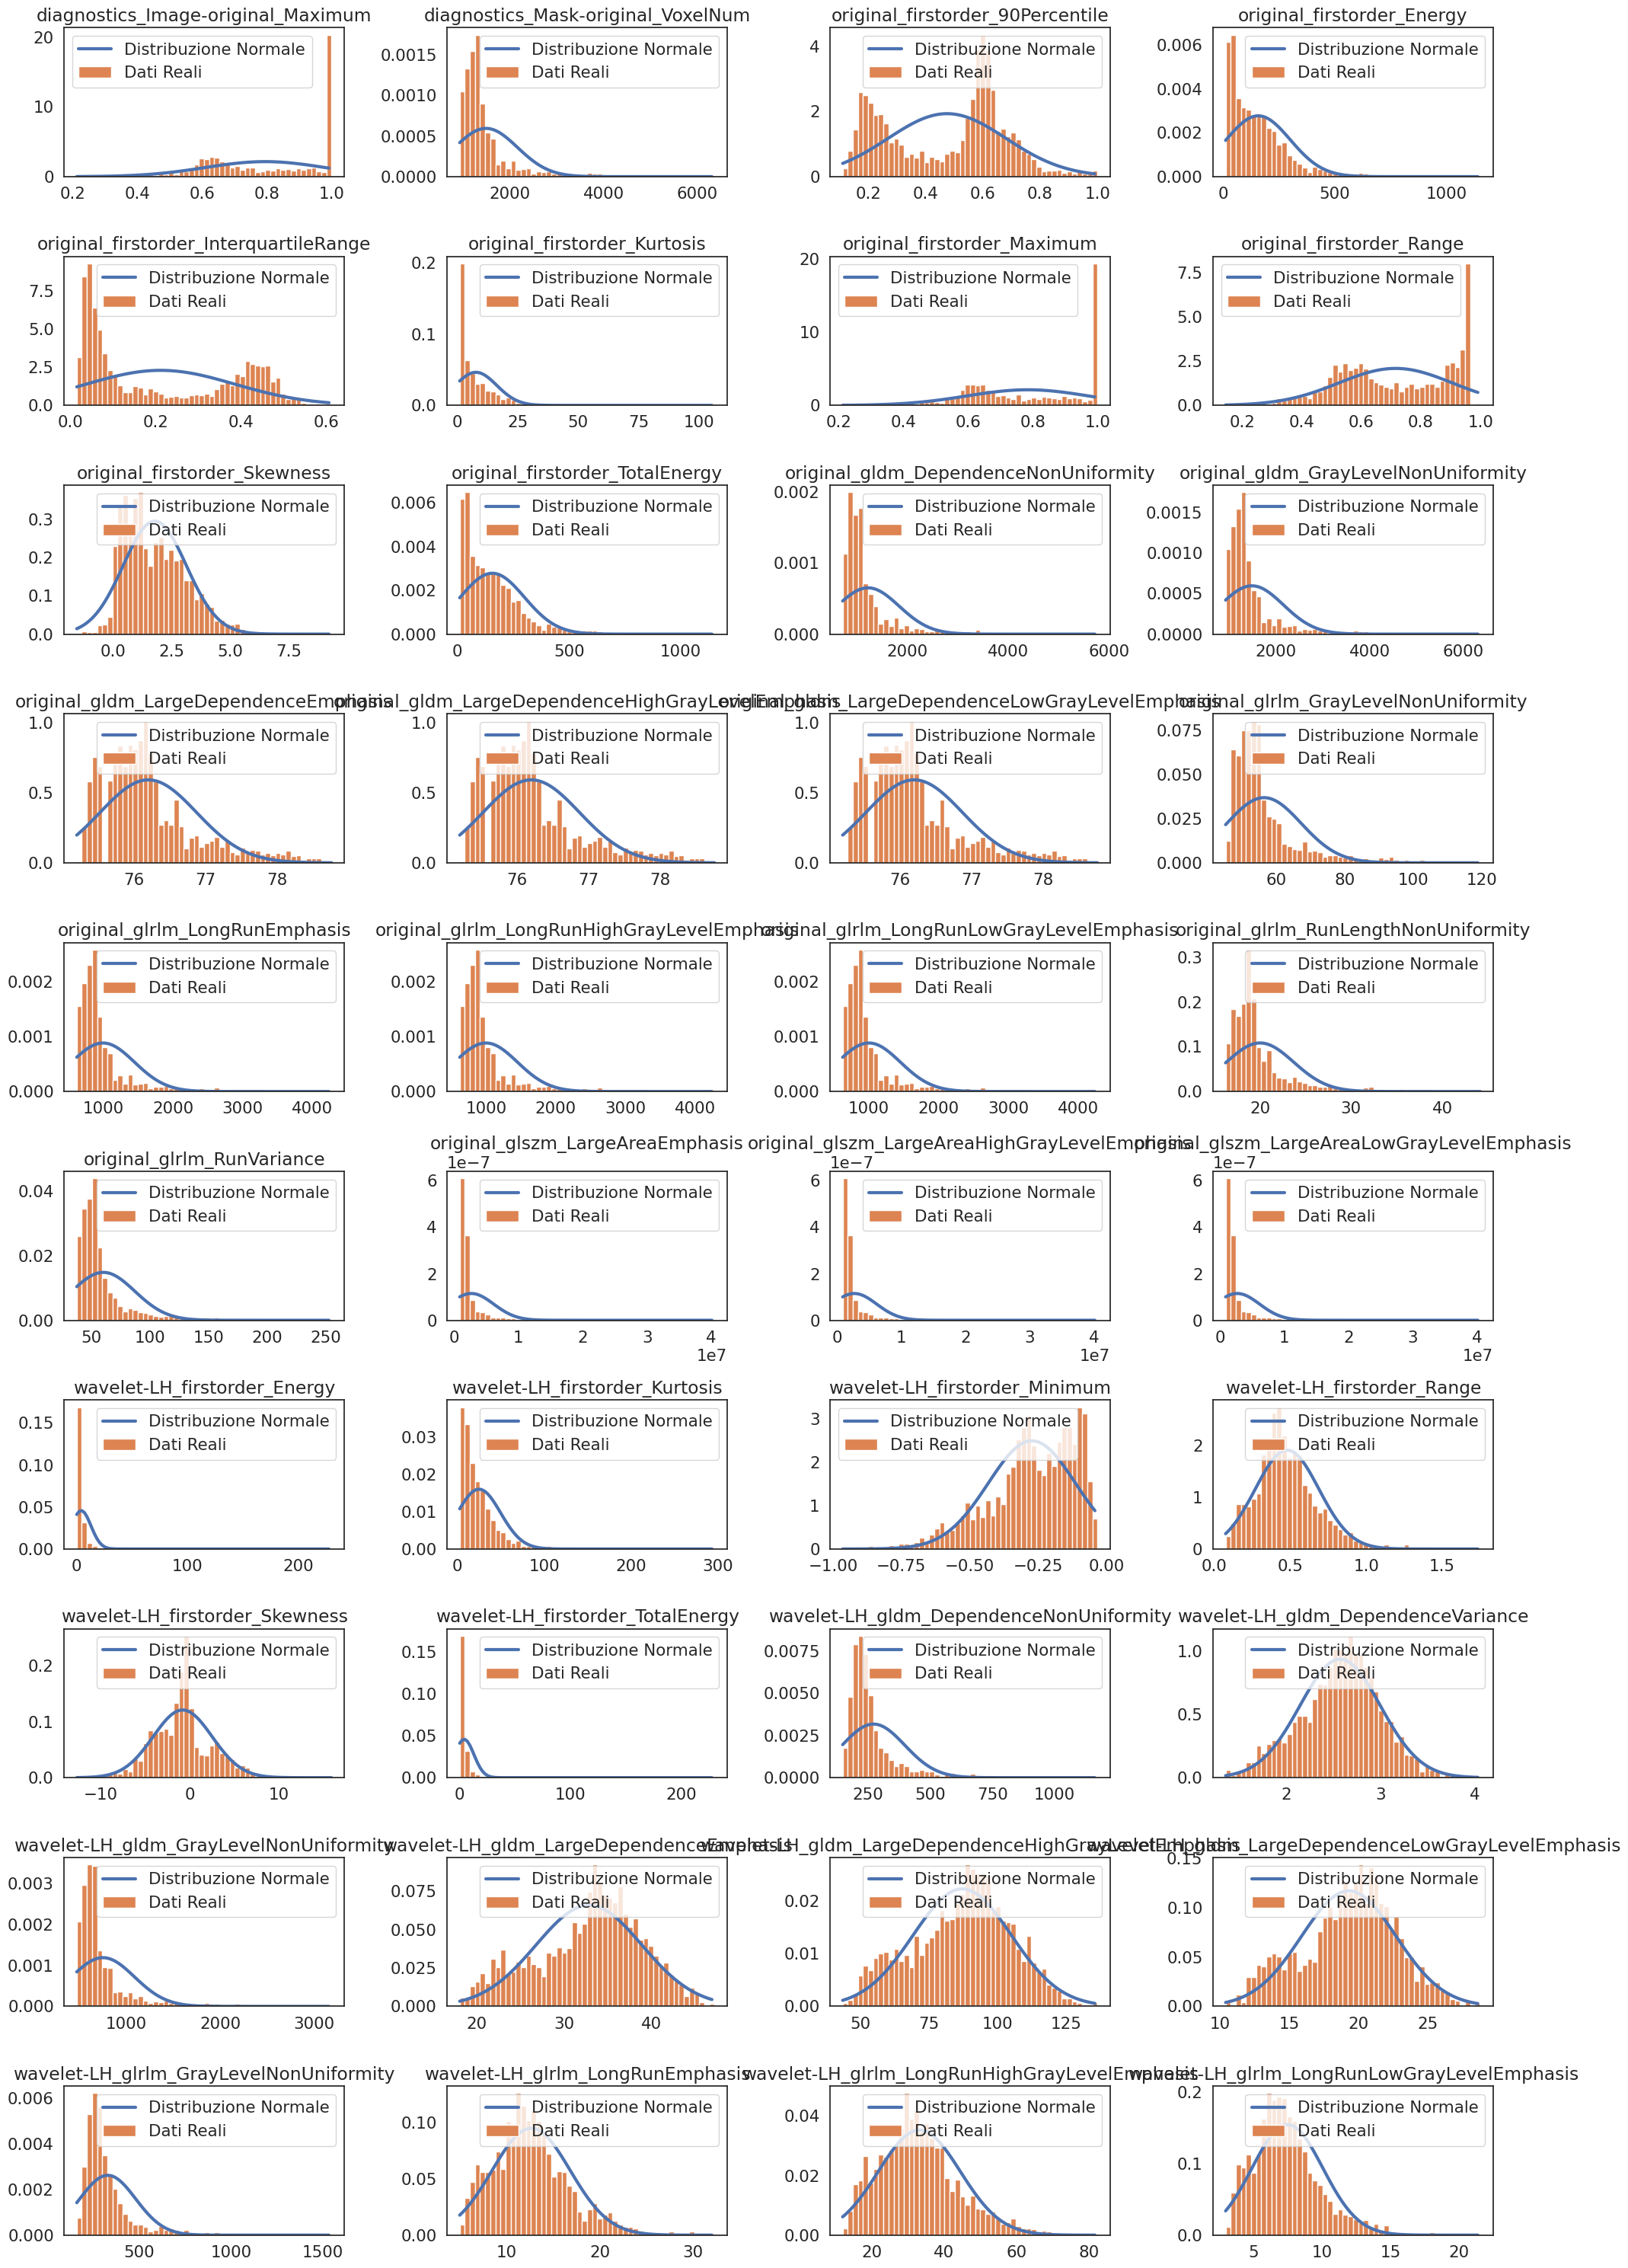

In [ ]:
# visual inspection

from scipy import stats
fig, axes = plt.subplots(nrows=10, ncols=4,figsize=(20, 30))
axes = axes.flatten()

# show
for i, col in enumerate(features_train_cleaned.columns[:40]):
    step = (features_train_cleaned[col].max() - features_train_cleaned[col].min()) / 100
    xs = np.arange(features_train_cleaned[col].min(), features_train_cleaned[col].max(), step)
    fit = stats.norm.pdf(xs, np.mean(features_train_cleaned[col]), np.std(features_train_cleaned[col]))

    axes[i].plot(xs, fit, label='Distribuzione Normale', lw=3)
    axes[i].hist(features_train_cleaned[col], 50, density=True, label='Dati Reali')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

# looking at the first 40 columns, the data seems quite normal distributed

5. Outliers

In [ ]:
features_train_outliers = features_train_cleaned.copy()

In [ ]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import numpy as np

feature_list = features_train_outliers.columns
print('Missing values before outlier removal: ' + str(features_train_outliers.isnull().sum().sum()))

# apply zscore
scaler = StandardScaler().fit(features_train_outliers)
zscore_features = scaler.transform(features_train_outliers)

# select all those values with zscore > -+ 3  as outliers
abs_zscores = np.abs(zscore_features)

outliers_detected = abs_zscores >  3
print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# set outliers as missing values
features_train_outliers[outliers_detected] = np.nan
print('Missing values after outlier removal (train): ' + str(features_train_outliers.isnull().sum().sum()))

Missing values before outlier removal: 0
Outliers detected (train): 3843
Missing values after outlier removal (train): 3843


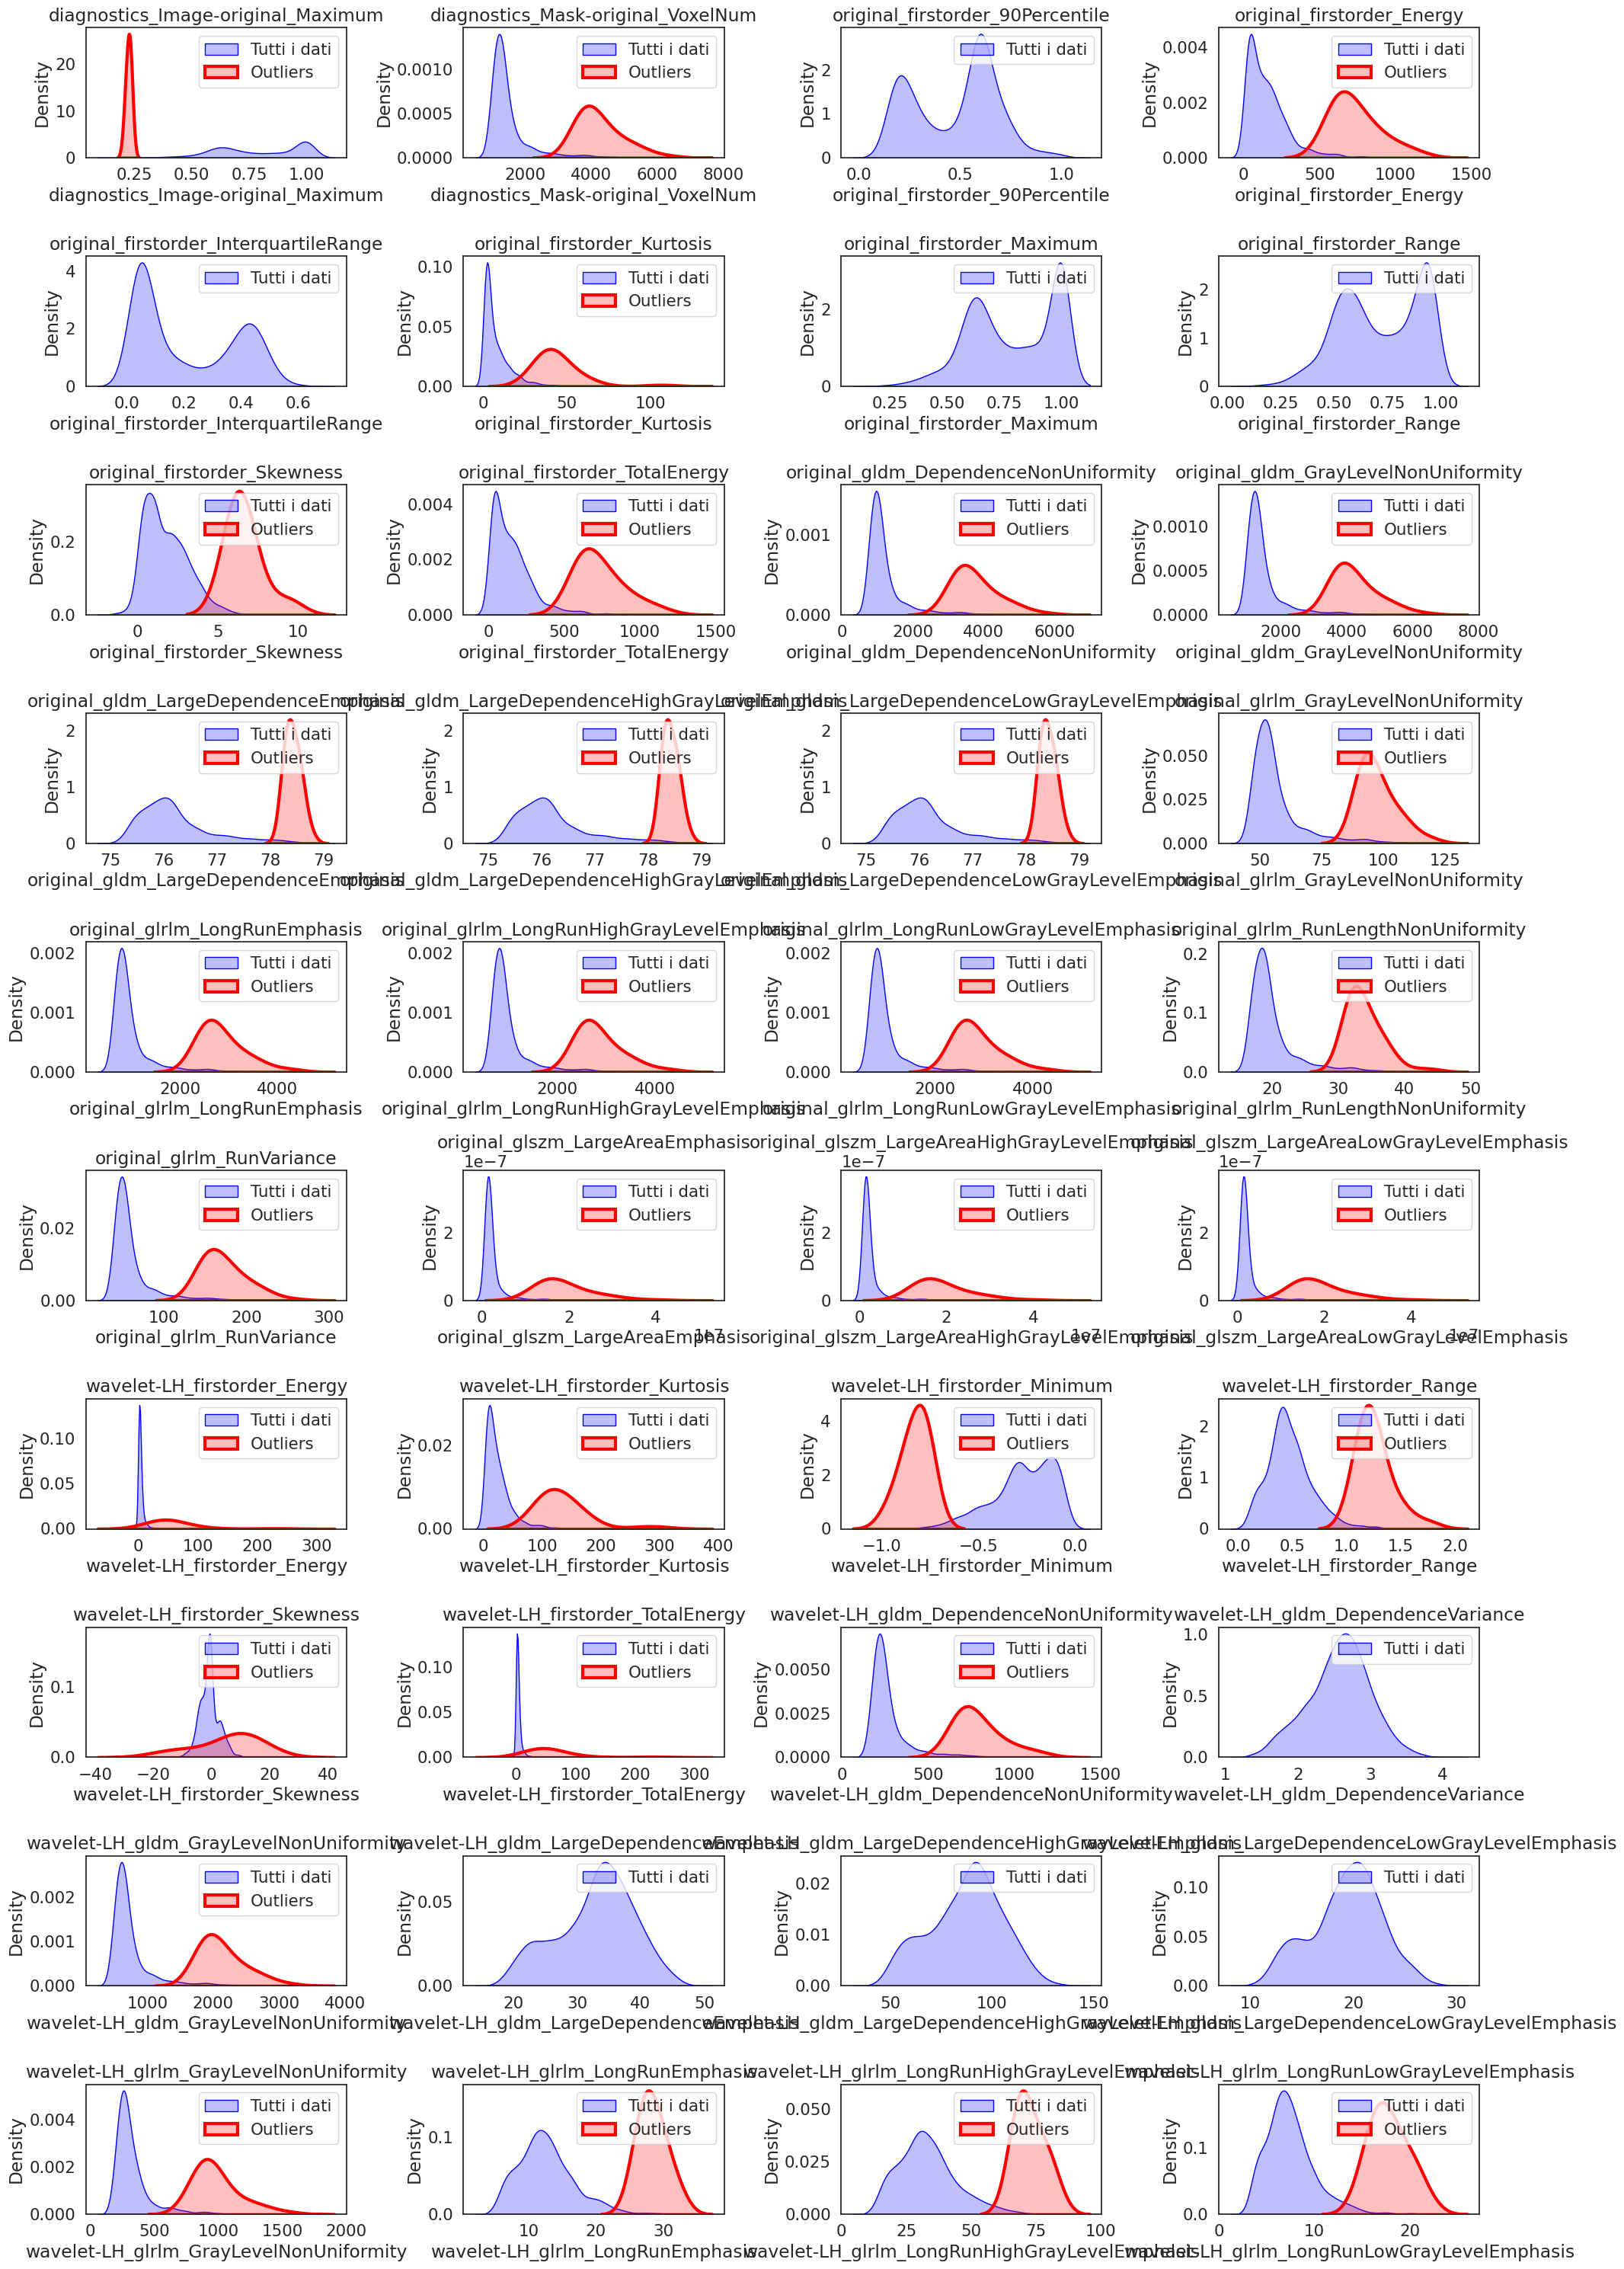

In [ ]:
# visualization
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(20, 30))
axes = axes.flatten()

for i, column_name in enumerate(features_train_cleaned.columns[:40]):
    outlier_values = features_train_cleaned[column_name][outliers_detected[:, i]]
    sns.kdeplot(features_train_cleaned[column_name], color='blue', label='Tutti i dati', fill=True, ax=axes[i])

    if len(outlier_values) > 0:
        sns.kdeplot(outlier_values, color='red', label='Outliers', fill=True, ax=axes[i], bw_adjust=1.5, linewidth=3)
    axes[i].set_title(f"{column_name}")
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()
# outlier distribution is different from the other data


In [ ]:
features_val_outliers=features_val_cleaned.copy()

In [ ]:
# Apply to validation set
zscore_features = scaler.transform(features_val_outliers)
abs_zscores = np.abs(zscore_features)
outliers_detected = abs_zscores > 3
print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))

features_val_outliers[outliers_detected] = np.nan
print('Missing values after outlier removal (validation): ' + str(features_val_outliers.isnull().sum().sum()))

Outliers detected (validation): 916
Missing values after outlier removal (validation): 916


In [ ]:
# Remove patients in training set with high percentage of missing data (only in the TRAINING)

# Step 1: identify the index to remove
indices_to_drop = features_train_outliers[features_train_outliers.isna().sum(axis=1) > (np.shape(features_train_outliers)[1] / 3)].index

# Step 2: Rimuovi the rows
features_train_outliers = features_train_outliers.drop(indices_to_drop)
y_train_nodule = np.delete(y_train_nodule, indices_to_drop, axis=0) # remove also in the image dataset
X_train_nodule = np.delete(X_train_nodule, indices_to_drop, axis=0) # remove also in the label dataset

# count the number of dropped samples
n_samples_before = np.shape(features_train_outliers)[0]+ len(indices_to_drop)
n_samples_after = np.shape(features_train_outliers)[0]

print('Number of samples dropped: ' + str(n_samples_before - n_samples_after))
print(f'Number of samples after: {len(y_train_nodule)}')

Number of samples dropped: 17
Number of samples after: 1803


In [ ]:
# Imputation
from sklearn.impute import KNNImputer
import pandas as pd

# sosbitution of the NaN using the KNNImputer (imputation method)
train_features = features_train_outliers
validation_features = features_val_outliers

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')  # define the imputer
imputer.fit(train_features)   # train the imputer on the training data

# make imputation
train_features_KNN = imputer.transform(train_features)
train_features_KNN = pd.DataFrame(data=train_features_KNN, columns=train_features.columns)

validation_features_KNN = imputer.transform(validation_features)
validation_features_KNN = pd.DataFrame(data=validation_features_KNN, columns=validation_features.columns)

In [ ]:
# Just to check:
# find the first Nan index
nan_index = features_train_outliers.isna().stack().idxmax()
nan_column = nan_index[1]
nan_row = nan_index[0]

# original value
original_value = features_train_cleaned.loc[nan_row, nan_column]

# new value
imputed_value = train_features_KNN.loc[nan_row, nan_column]

print(f"Valore originale in (colonna: {nan_column}, riga: {nan_row}): {original_value}")
print(f"Valore nuovo (colonna: {nan_column}, riga: {nan_row}): {imputed_value}")


Valore originale in (colonna: wavelet-HL_glszm_SizeZoneNonUniformity, riga: 7): 5.5
Valore nuovo (colonna: wavelet-HL_glszm_SizeZoneNonUniformity, riga: 7): 2.519473920793614


6. Standardization

In [ ]:
# STANDARDIZATION
# we tried with both type of standardization (Standardscaler, MinMaxScaler) and the second one gave better results
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

train_features = train_features_KNN
val_features = validation_features_KNN

transformer = MinMaxScaler(feature_range=(0, 1)).fit(train_features)
#transformer = StandardScaler().fit(train_features)
train_features = transformer.transform(train_features)
train_features = pd.DataFrame(data=train_features, columns=feature_list)

# adapt validation set
val_features = transformer.transform(val_features)
val_features = pd.DataFrame(data=val_features, columns=feature_list)

display(train_features)

diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                               1.000000                            0.449704   
1                               1.000000                            0.173176   
2                               0.455068                            0.130178   
3                               0.767793                            0.143984   
4                               0.505392                            0.158580   
...                                  ...                                 ...   
1798                            0.894321                            0.075740   
1799                            1.000000                            0.024458   
1800                            0.832495                            0.295858   
1801                            1.000000                            0.233136   
1802                            0.474479                            0.417751   

      original_firstorder_90Percentile  original_firstorder_Energy  \
0                             0.570727                    0.618224   
1                             0.557658                    0.387284   
2                             0.212360                    0.071017   
3                             0.609462                    0.387644   
4                             0.148315                    0.043283   
...                                ...                         ...   
1798                          0.719870                    0.320688   
1799                          0.690065                    0.319428   
1800                          0.388587                    0.147376   
1801                          0.226493                    0.148022   
1802                          0.431224                    0.221953   

      original_firstorder_InterquartileRange  original_firstorder_Kurtosis  \
0                                   0.673128                      0.037986   
1                                   0.707489                      0.045475   
2                                   0.041410                      0.216130   
3                                   0.796476                      0.007438   
4                                   0.086344                      0.265184   
...                                      ...                           ...   
1798                                0.644714                      0.038430   
1799                                0.815639                      0.027548   
1800                                0.065198                      0.171392   
1801                                0.067841                      0.443515   
1802                                0.157709                      0.080995   

      original_firstorder_Maximum  original_firstorder_Range  \
0                        1.000000                   0.953346   
1                        1.000000                   0.938613   
2                        0.482265                   0.464088   
3                        0.779673                   0.699202   
4                        0.530696                   0.531001   
...                           ...                        ...   
1798                     0.899727                   0.782689   
1799                     1.000000                   0.913444   
1800                     0.841064                   0.810313   
1801                     1.000000                   0.907305   
1802                     0.501364                   0.429098   

      original_firstorder_Skewness  original_firstorder_TotalEnergy  ...  \
0                         0.286467                         0.618224  ...   
1                         0.314229                         0.387284  ...   
2                         0.552744                         0.071017  ...   
3                         0.259972                         0.387644  ...   
4                         0.547081                         0.043283  ...   
...                            ...        

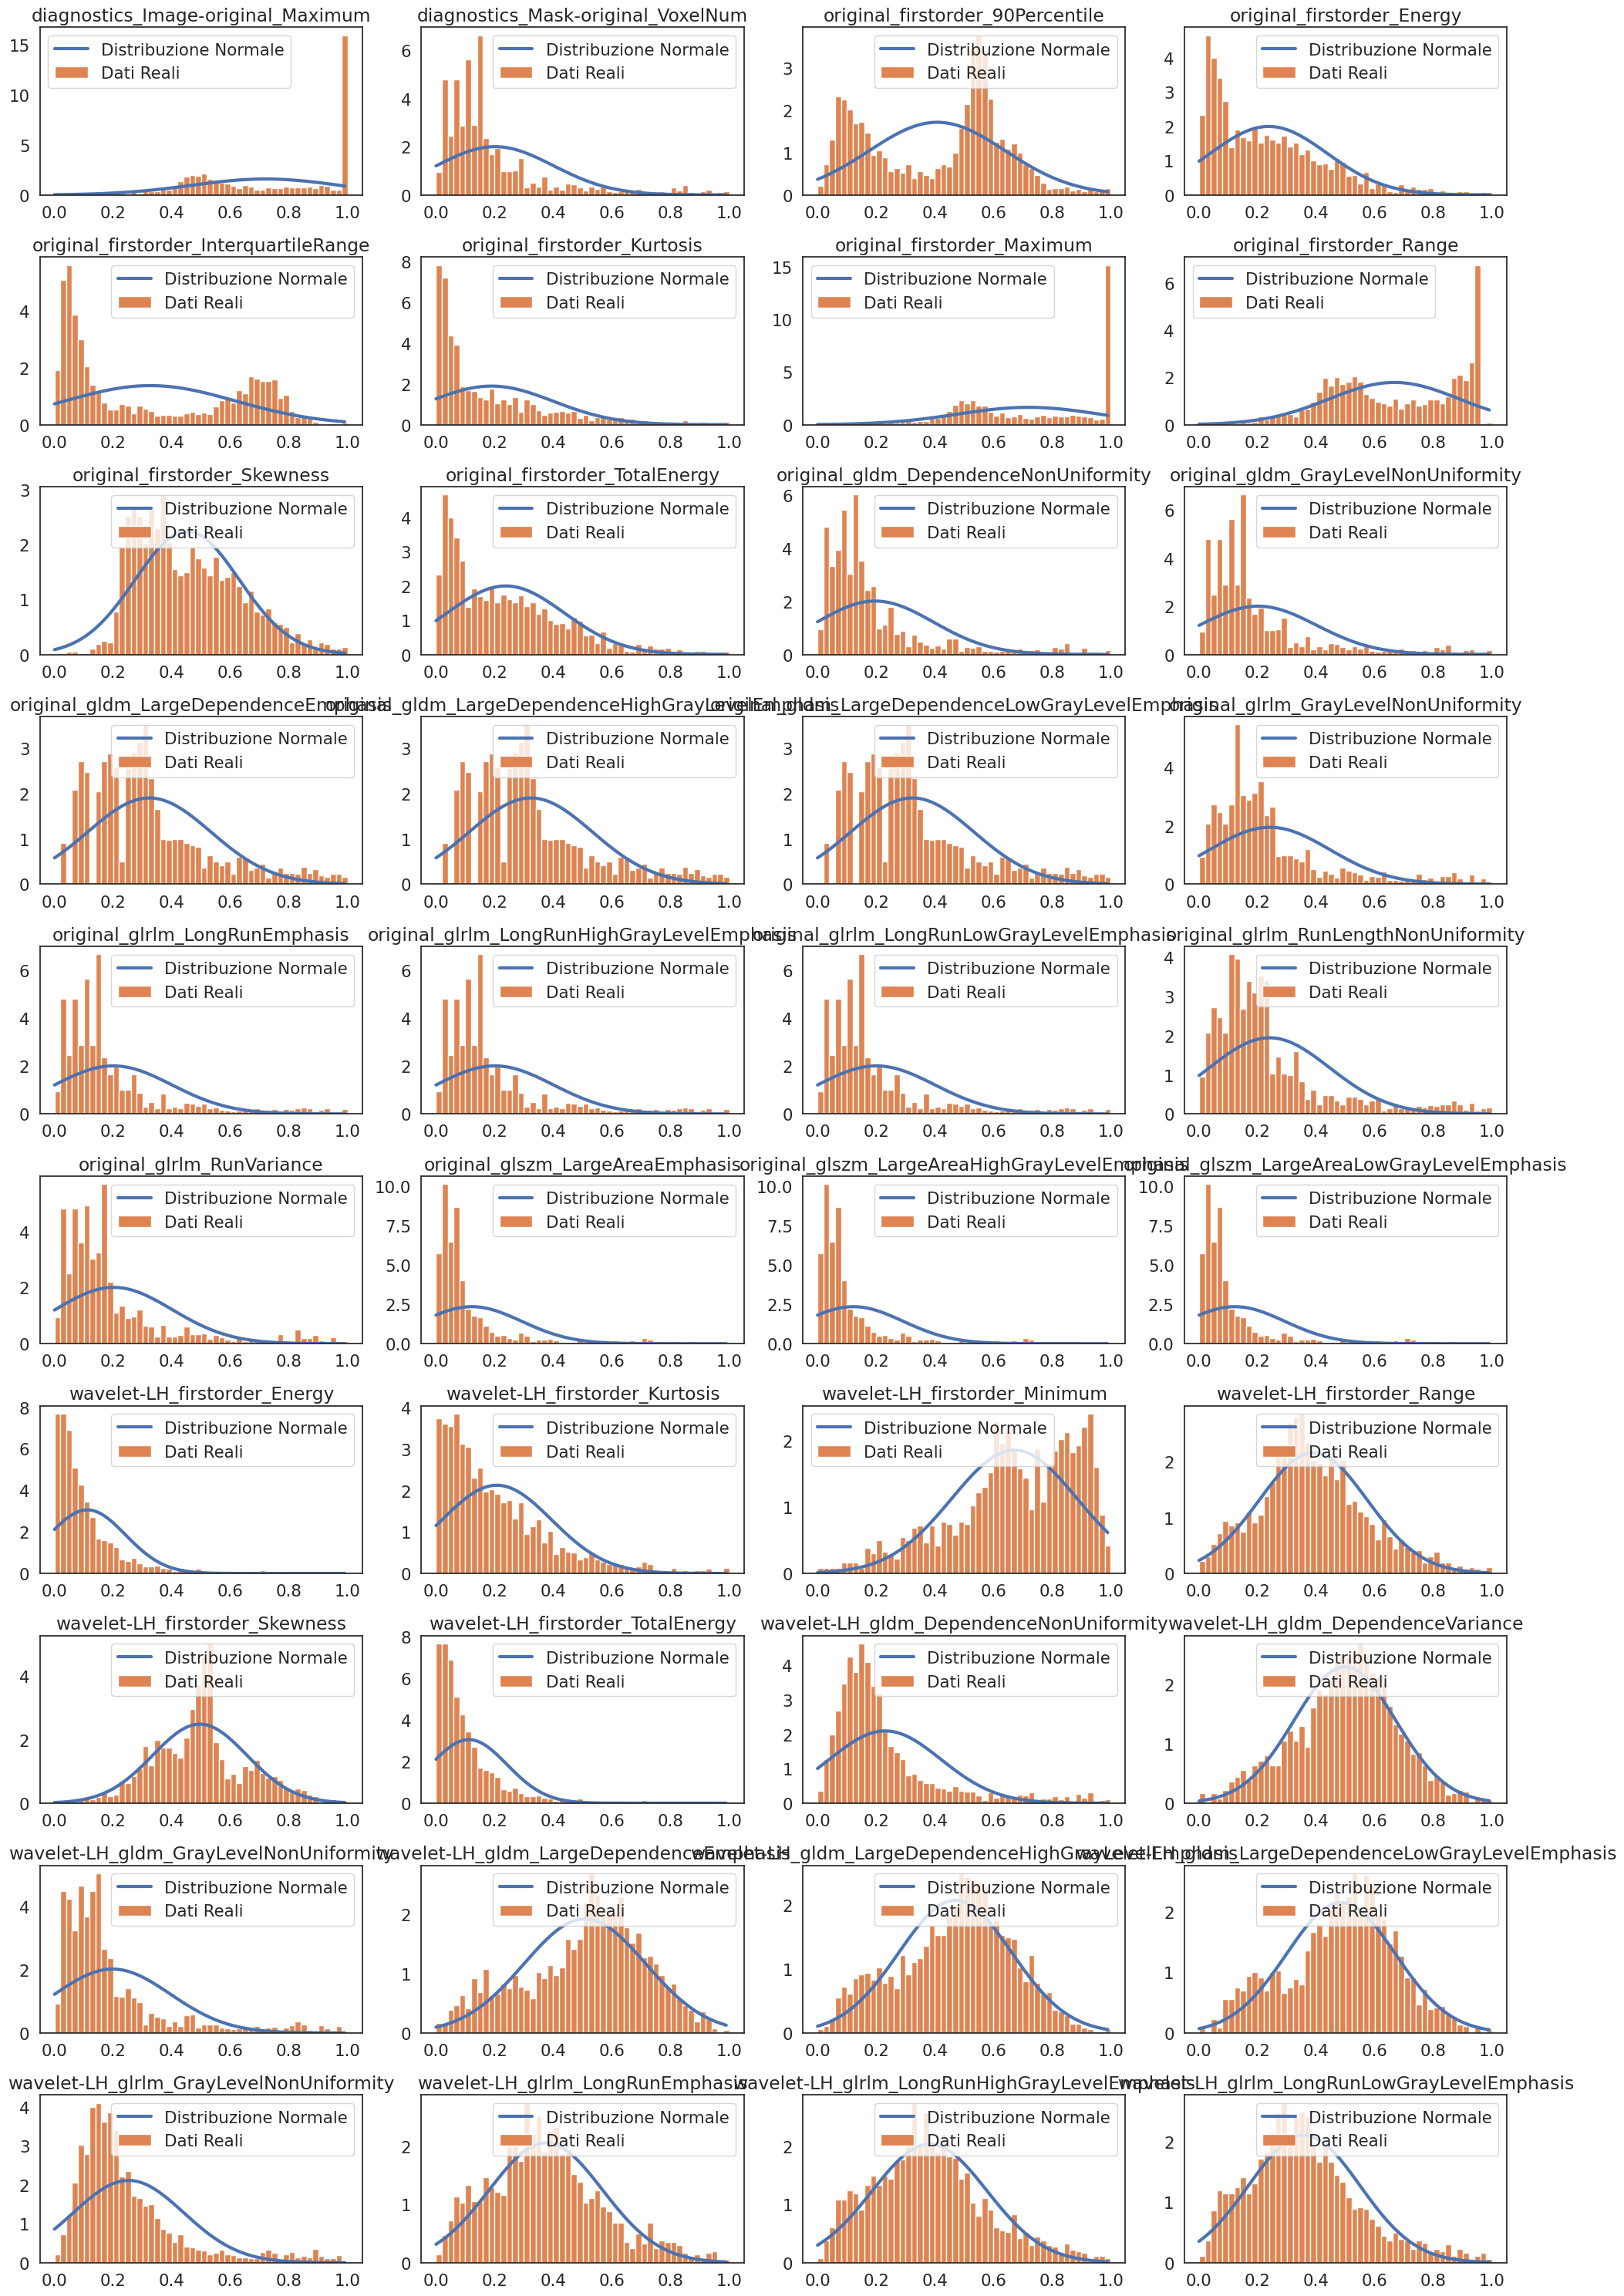

In [ ]:
# Show
fig, axes = plt.subplots(nrows=10, ncols=4,figsize=(20, 30))
axes = axes.flatten()

# visualization
for i, col in enumerate(train_features.columns[:40]):
    step = (train_features[col].max() - train_features[col].min()) / 100
    xs = np.arange(train_features[col].min(), train_features[col].max(), step)
    fit = stats.norm.pdf(xs, np.mean(train_features[col]), np.std(train_features[col]))

    axes[i].plot(xs, fit, label='Distribuzione Normale', lw=3)
    axes[i].hist(train_features[col], 50, density=True, label='Dati Reali')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()
# looking at the first 40 columns, the data seems quite normal distributed

7. Correlation btw features

In [ ]:
# Eliminate correlated features
correlated_features = set()
correlation_matrix = train_features.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8 :    #correlation thr=80%
            if median_corr[i] < median_corr[j]:   # I eliminate the feature that has an higher correlation with all the others
                colname = correlation_matrix.columns[j]
            else:
                colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
train_features.drop(labels=correlated_features, axis=1, inplace=True)
val_features.drop(labels=correlated_features, axis=1, inplace=True)
print('Deleted features: ' + str(correlated_features))
print(len(correlated_features))

# adapt test set: pick only selected features
feature_list = list(train_features.columns)
validation_features = validation_features[feature_list]



Deleted features: {'wavelet-LH_glrlm_ShortRunHighGrayLevelEmphasis', 'wavelet-LL_firstorder_Range', 'wavelet-HL_glrlm_RunLengthNonUniformity', 'diagnostics_Mask-original_VoxelNum', 'original_glrlm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'wavelet-HH_glrlm_LongRunHighGrayLevelEmphasis', 'wavelet-HL_gldm_LargeDependenceHighGrayLevelEmphasis', 'wavelet-LL_glszm_LargeAreaHighGrayLevelEmphasis', 'original_gldm_GrayLevelNonUniformity', 'wavelet-LH_ngtdm_Busyness', 'wavelet-LH_gldm_DependenceVariance', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'wavelet-HL_glrlm_RunEntropy', 'wavelet-LL_firstorder_90Percentile', 'wavelet-LH_gldm_GrayLevelNonUniformity', 'wavelet-LH_glrlm_LongRunEmphasis', 'wavelet-HH_gldm_DependenceNonUniformity', 'original_firstorder_Range', 'wavelet-LL_firstorder_MeanAbsoluteDeviation', 'original_firstorder_90Percentile', 'wavelet-HH_glrlm_LongRunLowGrayLevelEmphasis', 'wavelet-LL_glszm_LargeAreaLowGrayLevelEmphasis', 'diagnostics_Image-origin

In [ ]:
# transform labels to categorical
y_train_nodule=np.argmax(y_train_nodule, axis=1)
y_train_nodule
y_val_nodule=np.argmax(y_val_nodule, axis=1)
y_val_nodule

array([1, 0, 4, 3, 2, 2, 3, 4, 2, 1, 3, 2, 1, 3, 1, 1, 2, 0, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 2, 1, 1, 3, 3, 2, 0, 2, 2, 2,
       0, 0, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 4, 3, 2, 4, 0, 1, 1, 2, 4, 2,
       2, 1, 2, 4, 1, 3, 2, 1, 3, 2, 4, 2, 2, 1, 0, 4, 2, 0, 2, 2, 2, 1,
       2, 3, 2, 2, 2, 1, 1, 3, 3, 0, 2, 4, 2, 1, 2, 2, 2, 2, 3, 3, 3, 0,
       3, 1, 2, 3, 2, 3, 2, 1, 2, 3, 0, 2, 3, 2, 2, 1, 3, 1, 2, 3, 1, 2,
       2, 1, 0, 3, 4, 3, 1, 2, 4, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2, 4, 1, 1,
       0, 2, 2, 3, 1, 3, 4, 3, 2, 3, 2, 2, 2, 2, 1, 0, 2, 2, 4, 1, 2, 4,
       2, 2, 2, 1, 0, 2, 0, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 0, 2, 1, 1, 2, 0, 2, 2, 1,
       3, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 4, 2, 3,
       2, 0, 3, 1, 3, 1, 1, 3, 2, 2, 2, 2, 3, 2, 1, 4, 1, 0, 0, 2, 2, 1,
       2, 2, 3, 0, 4, 2, 3, 0, 2, 1, 2, 1, 3, 3, 3, 2, 3, 0, 1, 0, 3, 1,
       4, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 2, 3, 1, 3,

In [ ]:
train_features

wavelet-LH_firstorder_Energy  wavelet-LH_firstorder_Kurtosis  \
0                         0.180839                        0.099524   
1                         0.184692                        0.315476   
2                         0.054903                        0.412993   
3                         0.109704                        0.209085   
4                         0.067989                        0.012647   
...                            ...                             ...   
1798                      0.099129                        0.330217   
1799                      0.034336                        0.403344   
1800                      0.188611                        0.157611   
1801                      0.027603                        0.301386   
1802                      0.059343                        0.046370   

      wavelet-LH_firstorder_Minimum  wavelet-LH_firstorder_Range  \
0                          0.601632                     0.429623   
1                          0.173393                     0.799025   
2                          0.588886                     0.323128   
3                          0.956568                     0.284702   
4                          0.853128                     0.219361   
...                             ...                          ...   
1798                       0.359679                     0.493405   
1799                       0.836759                     0.369619   
1800                       0.314743                     0.810952   
1801                       0.679905                     0.286203   
1802                       0.849161                     0.175793   

      wavelet-LH_firstorder_Skewness  \
0                           0.448940   
1                           0.329463   
2                           0.274422   
3                           0.747325   
4                           0.535432   
...                              ...   
1798                        0.295978   
1799                        0.734246   
1800                        0.483541   
1801                        0.387398   
1802                        0.513118   

      wavelet-LH_glrlm_LongRunHighGrayLevelEmphasis  \
0                                          0.535701   
1                                          0.305784   
2                                          0.243297   
3                                          0.830210   
4                                          0.064432   
...                                             ...   
1798                                       0.458259   
1799                                       0.298998   
1800                                       0.174095   
1801                                       0.668241   
1802                                       0.520294   

      wavelet-LH_glszm_GrayLevelNonUniformity  \
0                                    0.655969   
1                                    0.379452   
2                                    0.346575   
3                                    0.331651   
4                                    0.265411   
...                                       ...   
1798                                 0.442270   
1799                                 0.584110   
1800                                 0.544784   
1801                                 0.346575   
1802                                 0.648696   

      wavelet-LH_glszm_HighGrayLevelZoneEmphasis  \
0                                       0.571051   
1                                       0.836123   
2                                       0.561233   
3                                       0.738465   
4                                       0.544053   
...                                          ...   
1798                                    0.335431   
1799                                    0.272599   
1800                                    0.365639   
1801                                    0.561233   
1802                                    0.386

8. RFE (Recurrent feature elimination)

Optimal number of features : 18


ranking  selected
wavelet-LH_firstorder_Energy                             5     False
wavelet-LH_firstorder_Kurtosis                          11     False
wavelet-LH_firstorder_Minimum                            4     False
wavelet-LH_firstorder_Range                             17     False
wavelet-LH_firstorder_Skewness                           1      True
wavelet-LH_glrlm_LongRunHighGrayLevelEmphasis           12     False
wavelet-LH_glszm_GrayLevelNonUniformity                  1      True
wavelet-LH_glszm_HighGrayLevelZoneEmphasis              16     False
wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis          1      True
wavelet-LH_glszm_SizeZoneNonUniformity                   3     False
wavelet-LH_glszm_SmallAreaHighGrayLevelEmphasis         10     False
wavelet-LH_glszm_ZoneEntropy                             1      True
wavelet-HL_firstorder_Energy                             1      True
wavelet-HL_firstorder_Kurtosis                          13     False
wavelet-HL_firstorder_Minimum                            1      True
wavelet-HL_firstorder_Range                              6     False
wavelet-HL_firstorder_Skewness                           1      True
wavelet-HL_gldm_DependenceVariance                       1      True
wavelet-HL_glszm_GrayLevelNonUniformity                  1      True
wavelet-HL_glszm_HighGrayLevelZoneEmphasis              14     False
wavelet-HL_glszm_LargeAreaHighGrayLevelEmphasis          1      True
wavelet-HL_glszm_SizeZoneNonUniformity                   1      True
wavelet-HL_glszm_SmallAreaHighGrayLevelEmphasis          1      True
wavelet-HL_glszm_ZoneEntropy                             1      True
wavelet-HH_firstorder_Energy                             1      True
wavelet-HH_firstorder_Kurtosis                           7     False
wavelet-HH_firstorder_Skewness                           9     False
wavelet-HH_glrlm_RunVariance                             8     False
wavelet-HH_glszm_GrayLevelNonUniformity                 18     False
wavelet-HH_glszm_HighGrayLevelZoneEmphasis              19     False
wavelet-HH_glszm_SizeZoneNonUniformity                  21     False
wavelet-HH_glszm_SmallAreaEmphasis                      15     False
wavelet-HH_glszm_SmallAreaHighGrayLevelEmphasis          1      True
wavelet-HH_glszm_ZoneEntropy                            20     False
wavelet-LL_firstorder_Maximum                            1      True
wavelet-LL_firstorder_Median                             2     False
wavelet-LL_firstorder_RobustMeanAbsoluteDeviation        1      True
wavelet-LL_glcm_Autocorrelation                         22     False
wavelet-LL_glcm_SumAverage                              24     False
wavelet-LL_gldm_HighGrayLevelEmphasis                   25     False
wavelet-LL_glrlm_HighGrayLevelRunEmphasis               26     False
wavelet-LL_glrlm_LongRunLowGrayLevelEmphasis             1      True
wavelet-LL_glszm_ZoneVariance                           23     False
wavelet-LL_ngtdm_Coarseness                             27     False

mean_test_score  std_test_score  split0_test_score  split1_test_score  \
0          0.233201        0.017110           0.240823           0.249278   
1          0.268122        0.009184           0.267970           0.256949   
2          0.415922        0.034163           0.399134           0.385082   
3          0.407701        0.006714           0.398279           0.411393   
4          0.416788        0.009185           0.408924           0.411767   
5          0.414596        0.002102           0.411632           0.415883   
6          0.423713        0.009007           0.435964           0.420610   
7          0.414830        0.009080           0.427656           0.408940   
8          0.421151        0.004217           0.415478           0.425578   
9          0.410243        0.016814           0.424111           0.420036   
10         0.414772        0.018996           0.436935           0.416838   
11         0.421452        0.010941           0.436404           0.417422   
12         0.419470        0.008677           0.422920           0.427944   
13         0.422730        0.020932           0.447603           0.424194   
14         0.411919        0.009994           0.400534           0.424865   
15         0.427979        0.006838           0.437649           0.423226   
16         0.423481        0.013804           0.416002           0.442837   
17         0.428076        0.017769           0.448839           0.429951   
18         0.416265        0.012172           0.429205           0.419626   
19         0.426354        0.018251           0.440585           0.437888   
20         0.409439        0.015844           0.417589           0.423439   
21         0.420287        0.015655           0.439794           0.419601   
22         0.418647        0.014820           0.414225           0.438600   
23         0.423023        0.011223           0.423176           0.409202   
24         0.409420        0.006700           0.414832           0.413449   
25         0.417291        0.009437           0.419089           0.427844   
26         0.409555        0.011695           0.410096           0.423600   
27         0.418643        0.005864           0.423629           0.421889   
28         0.406546        0.017698           0.422062           0.415797   
29         0.406071        0.014978           0.411750           0.420904   
30         0.409431        0.004332           0.415165           0.404698   
31         0.410271        0.009539           0.423722           0.402653   
32         0.403381        0.017003           0.421215           0.408433   
33         0.398961        0.020067           0.421607           0.402451   
34         0.402285        0.018165           0.419996           0.409545   
35         0.412120        0.020924           0.441150           0.402566   
36         0.421872        0.020359           0.443941           0.426852   
37         0.402015        0.020419           0.429560           0.395745   
38         0.411463        0.014407           0.416580           0.425984   
39         0.403857        0.015085           0.416141           0.412822   
40         0.404239        0.008997           0.413473           0.407202   
41         0.387426        0.007287           0.396553           0.387007   
42         0.396932        0.014134           0.416824           0.385280   
43         0.396407        0.007687           0.398025           0.404909   

    split2_test_score  
0            0.209502  
1            0.279445  
2            0.463550  
3            0.413430  
4            0.429674  
5            0.416274  
6            0.414566  
7            0.407892  
8            0.422398  
9            0.386581  
10           0.390542  
11           0.410529  
12           0.407547  
13           0.396394  
14           0.410360  
15           0.423064  
16           0.411604  
17           0.405437  
18           0.399963  
19           0.400590  
20           0.387287  
21        

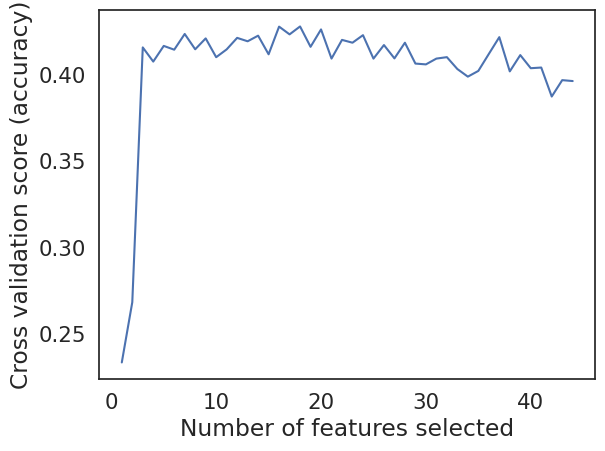

In [ ]:
# we use a model (SVM/Random Forest) that assigns a weight to each feature depending on its importance
# we select the one with the lowest weight and we eliminate it

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  n_features = len(rfecv.cv_results_['mean_test_score'])
  plt.plot(range(min_features_to_select, min_features_to_select + n_features), rfecv.cv_results_['mean_test_score'])
  plt.show()


# Create the RFE object and compute a cross-validated score.
min_features_to_select = 1

## SVM
#svc = SVC(kernel="linear")
#rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3),
#              scoring='balanced_accuracy',
#              min_features_to_select=min_features_to_select)

## RANDOM FOREST
rf = RandomForestClassifier(n_estimators=100)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(3), scoring='balanced_accuracy',
              min_features_to_select=min_features_to_select)


rfecv.fit(train_features, y_train_nodule) #fit
print("Optimal number of features : %d" % rfecv.n_features_)

# adapt train & validation set
train_features = train_features.iloc[:, rfecv.support_]
val_features = val_features[train_features.columns]

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plot_recurrentFE(min_features_to_select, rfecv)

# with RFE 18 features were selected

In [ ]:
print(train_features.shape)
print(val_features.shape)

(1803, 18)
(456, 18)


wavelet-LH_firstorder_Skewness                      -0.001976
wavelet-LH_glszm_GrayLevelNonUniformity              0.230018
wavelet-LH_glszm_LargeAreaHighGrayLevelEmphasis      0.368319
wavelet-LH_glszm_ZoneEntropy                         0.136203
wavelet-HL_firstorder_Energy                         0.178018
wavelet-HL_firstorder_Minimum                       -0.023524
wavelet-HL_firstorder_Skewness                       0.008784
wavelet-HL_gldm_DependenceVariance                  -0.088349
wavelet-HL_glszm_GrayLevelNonUniformity              0.317158
wavelet-HL_glszm_LargeAreaHighGrayLevelEmphasis      0.364619
wavelet-HL_glszm_SizeZoneNonUniformity               0.293806
wavelet-HL_glszm_SmallAreaHighGrayLevelEmphasis      0.053578
wavelet-HL_glszm_ZoneEntropy                         0.193024
wavelet-HH_firstorder_Energy                         0.121077
wavelet-HH_glszm_SmallAreaHighGrayLevelEmphasis      0.076825
wavelet-LL_firstorder_Maximum                       -0.166839
wavelet-

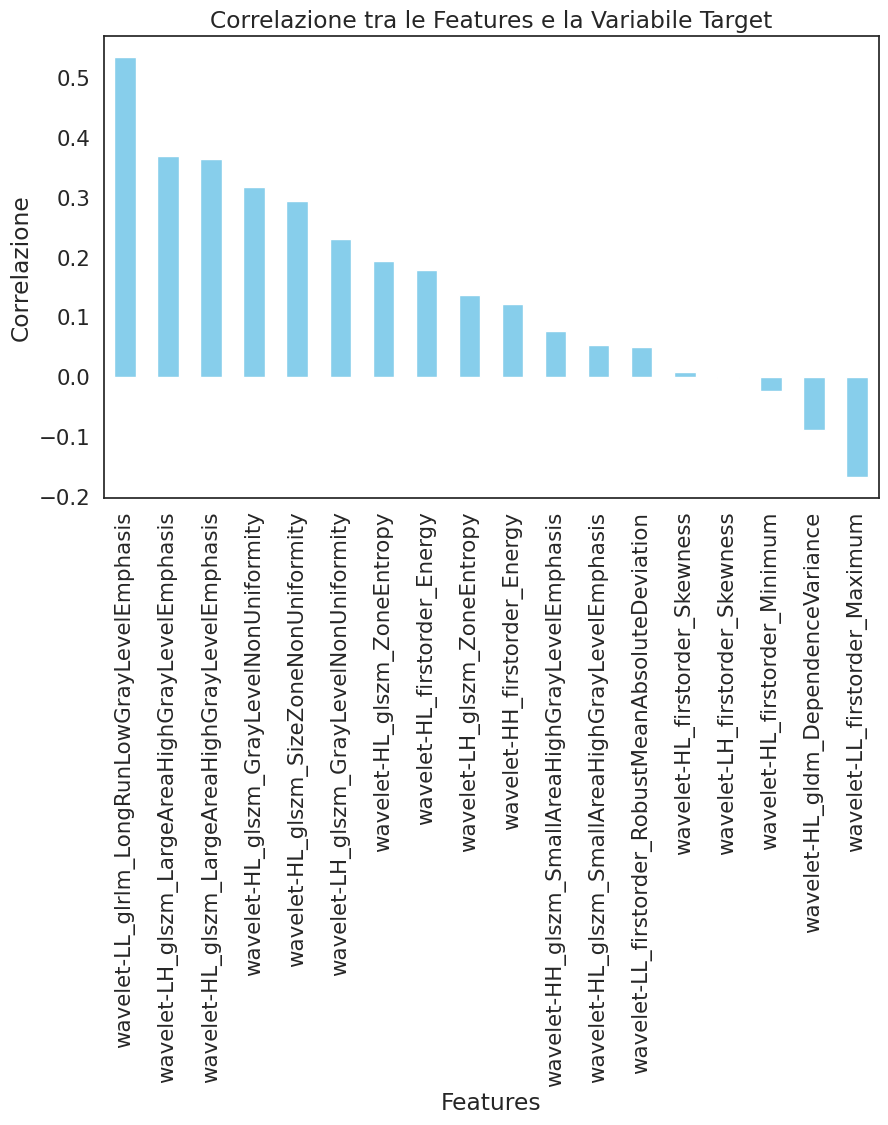

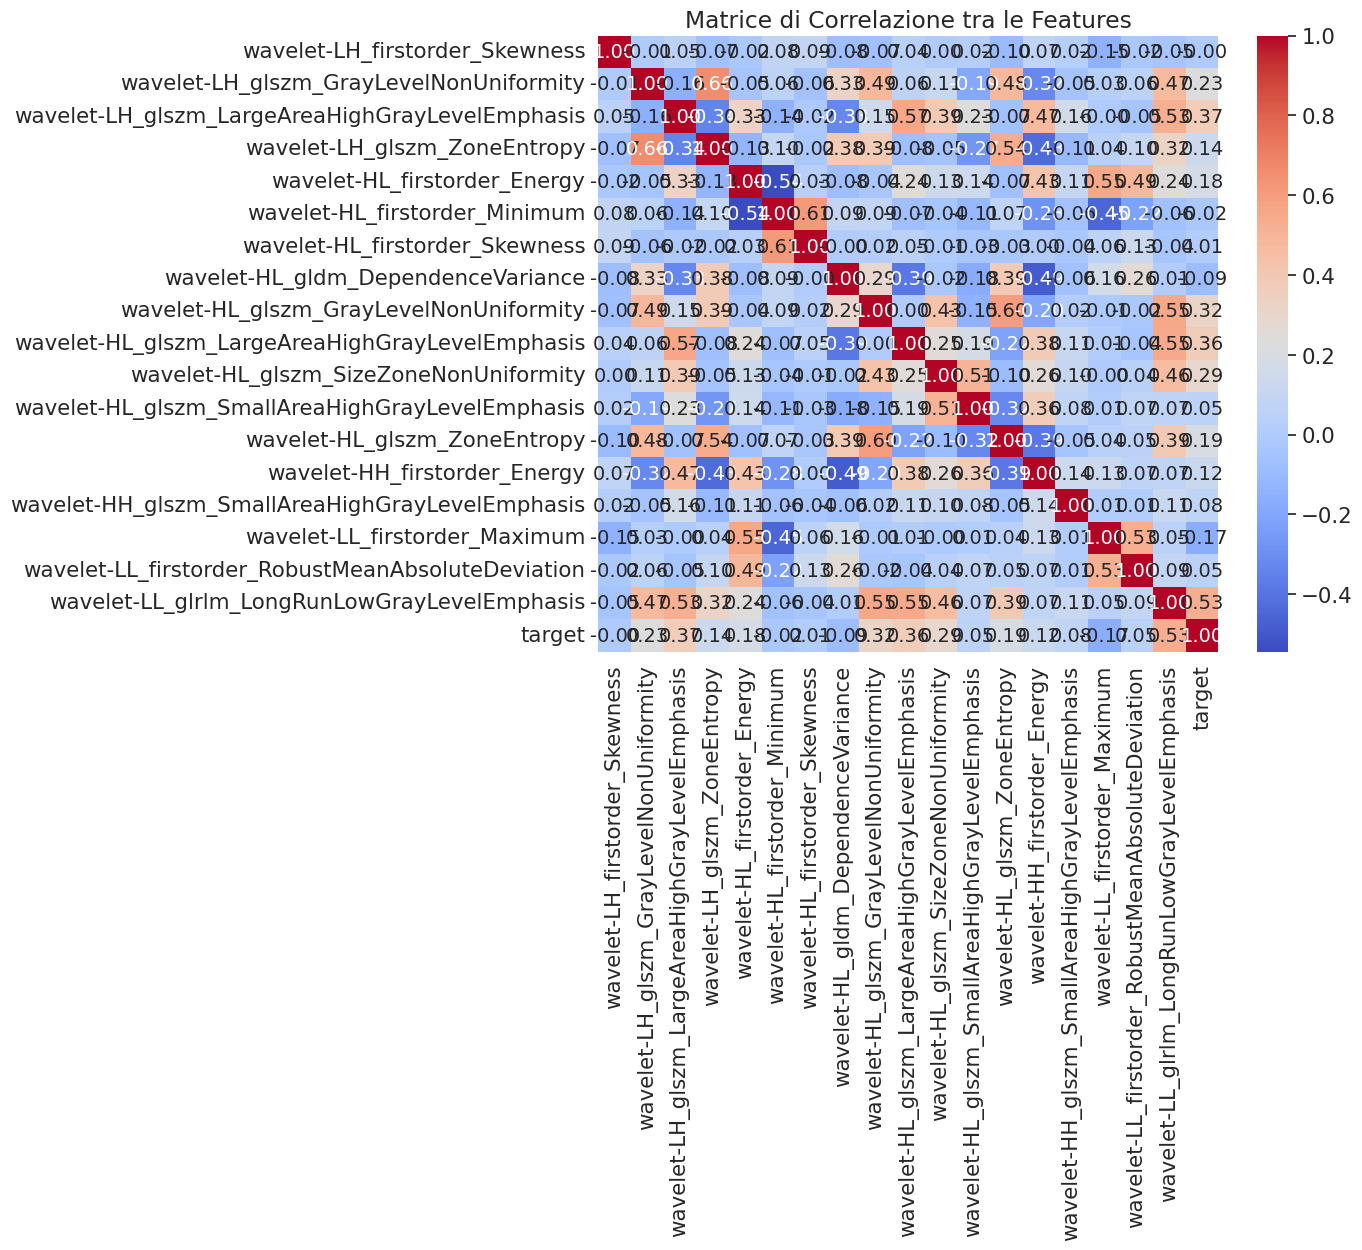

In [ ]:
# Aggiungi la variabile target al dataset come colonna
df=train_features.copy()
df['target'] = y_train_nodule

# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Correlazione con la variabile target
target_correlation = correlation_matrix['target']  # Correlazione con la variabile target
print(target_correlation)

# Visualizza la correlazione con la variabile target tramite un grafico a barre
plt.figure(figsize=(10, 6))
target_correlation.drop('target').sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Correlazione tra le Features e la Variabile Target')
plt.ylabel('Correlazione')
plt.xlabel('Features')
plt.show()


# Visualizza la matrice di correlazione usando una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matrice di Correlazione tra le Features')
plt.show()

## 🎨 Augmentation

In [ ]:
from tensorflow import keras
augmentation= keras.Sequential([
    # trasformazioni geometriche
    #keras_cv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3), # applica ≠ trasformazioni casualmente (scalamento, rotazioni, ...)
    tfkl.RandomFlip("horizontal and vertical", seed=seed),  # Ribaltamenti solo orizzontali (verticale non ha senso)
    #tfkl.RandomTranslation(0.2, 0.2, fill_mode='wrap', seed=seed),  # Maggiore traslazione
    tfkl.RandomRotation(0.1, fill_mode='reflect', seed=seed),  # Rotazioni
    #tfkl.RandomZoom(height_factor=0.5, width_factor=0.5, fill_mode='nearest', seed=seed),
    #keras_cv.layers.RandomShear(x_factor=0.5, y_factor=0.5),   # distorsioni geometriche (immagini inclinate),
    #tfkl.RandomCrop(height=56, width=56),
    #tfkl.Resizing(height=64, width=64),  # Resize back to 64x64

    # tecniche di mescolamento
    #keras_cv.layers.CutMix(), # sostituisce una porzione di immagine con una di un'altra immagine
    #keras_cv.layers.MixUp(),  # somma due imagini in maniera lineare
    #keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2), # non ha senso qui (magari mi oscura il tumore)

    # trasformazioni di colore/canale
    # keras_cv.layers.RandomChannelShift(factor=0.1, value_range=(0, 1)),   # disturbi cromatici
    #keras_cv.layers.RandomSaturation(factor=0.4),    # no for grayscale images
    #tfkl.RandomBrightness(0.4, value_range=(0,1), seed=seed),  # Variazione luminosità ridotta
    #keras_cv.layers.AutoContrast(value_range=(0, 1)),
    #keras_cv.layers.RandomSharpness(factor=0.4, value_range=(0, 1)),
], name='augmentation')

In [ ]:
# Prendi 4 immagini casuali da X_train
sample_images = X_train_nodule[np.random.choice(X_train_nodule.shape[0], 4, replace=False)]
sample_labels = y_train_nodule[np.random.choice(y_train_nodule.shape[0], 4, replace=False)]

# Crea una figura per visualizzare le immagini
plt.figure(figsize=(12, 12))

# Applica l'augmentation su ciascuna immagine e visualizzale
for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    # Aggiungi una dimensione batch (aggiungi una dimensione in più per batch)
    image_batch = image[tf.newaxis]

    # Applica l'augmentation
    augmented_image = augmentation(image_batch)  # Restituisce direttamente il tensore aumentato

    # Rimuovi la dimensione batch per visualizzare l'immagine
    augmented_image = augmented_image[0].numpy()

    # Normalizza i valori delle immagini tra 0 e 1 per la visualizzazione
    #image = (image - image.min()) / (image.max() - image.min())
    #augmented_image = (augmented_image - augmented_image.min()) / (augmented_image.max() - augmented_image.min())

    # Visualizza l'immagine originale (a sinistra) e l'immagine aumentata (a destra)
    plt.subplot(4, 2, 2 * i + 1)  # Colonna per le immagini originali
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Original - Label {label}")

    plt.subplot(4, 2, 2 * i + 2)  # Colonna per le immagini aumentate
    plt.imshow(augmented_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Augmented - Label {label}")

plt.tight_layout()
plt.show()

## 🏗️ Model

### 1.basic CNN

First we trained different CNN. Here we report the one that obtained the best performance

In [ ]:
from tensorflow.keras import regularizers

seed=42
def build_model(
    input_shape=(64,64,1),
    output_shape=5,
    augmentation=augmentation,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    # Apply augmentation
    x = augmentation(input_layer)

    # first convolutional layer
    x=res_block(x,64)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout1')(x)

    # second convolutional layer, activation, and pooling
    x = tfkl.Conv2D(filters=128, kernel_size=3,kernel_regularizer=regularizers.l2(0.01), padding='same', name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout2')(x)

    # third convolutional layer, activation, and pooling
    x=res_block(x,256)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout3')(x)

    # fourth convolutional layer, activation, and pooling
    #x=res_block(x,128)
    x = tfkl.Conv2D(filters=512, kernel_size=3,kernel_regularizer=regularizers.l2(0.01), padding='same', name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout4')(x)

    # fourth convolutional layer, activation, and pooling
    x=res_block(x,1024)
    x = tfkl.MaxPooling2D(name='mp4')(x)
    x = se_block(x)
    x = tfkl.Dropout(0.3, name='dropout5')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    #x = tfkl.BatchNormalization(name='bn_dense')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu_dense')(x)
    x = tfkl.Dropout(0.5)(x)
    output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(x)

    # create the model
    model_5 = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Return the compiled model
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ keras_tensor_14CLONE   │ (None, None, None,   │            0 │ -                   │    -    │
│ (InputLayer)           │ 1)                   │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, None, None,   │          640 │ keras_tensor_14CLO… │    Y    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, None, None,   │          256 │ conv2d[1][0]        │    Y    │
│ (BatchNormalization)   │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu (ReLU)           │ (None, None, None,   │            0 │ batch_normalizatio… │    -    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, None, None,   │       36,928 │ re_lu[1][0]         │    Y    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, None, None,   │          256 │ conv2d_1[1][0]      │    Y    │
│ (BatchNormalization)   │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, None, None,   │          128 │ keras_tensor_14CLO… │    Y    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, None, None,   │            0 │ batch_normalizatio… │    -    │
│                        │ 64)                  │              │ conv2d_2[1][0]      │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu_1 (ReLU)         │ (None, None, None,   │            0 │ add[1][0]           │    -    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ mp0 (MaxPooling2D)     │ (None, None, None,   │            0 │ re_lu_1[1][0]       │    -    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 64)           │            0 │ mp0[1][0]           │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 4)            │          260 │ global_average_poo… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_1 (Dense)        │ (None, 64)           │          320 │ dense[1][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ dense_1[1][0]       │    -    │
├──────────────────────

 Total params: 17,214,977 (65.67 MB)

 Trainable params: 17,208,321 (65.64 MB)

 Non-trainable params: 6,656 (26.00 KB)

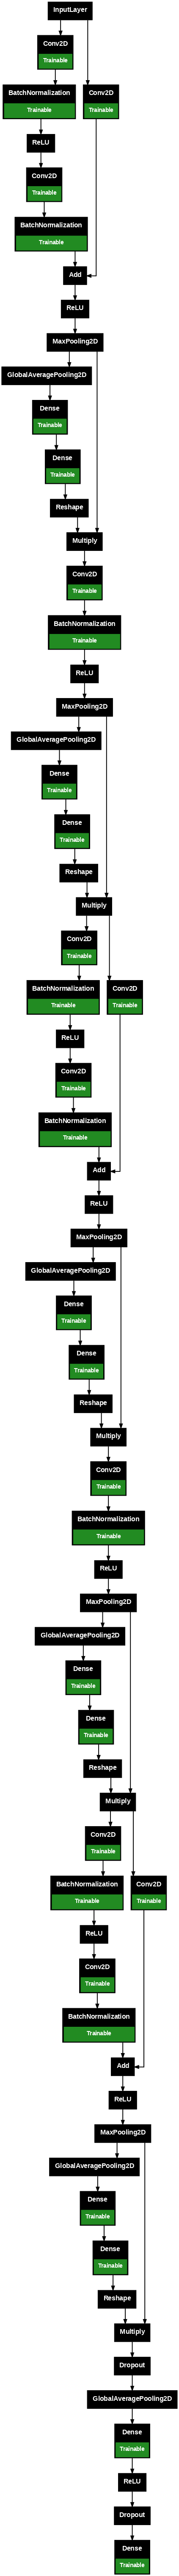

In [ ]:
# Build the model with specified input and output shapes
model = build_model()
#model = build_model(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True,  dpi=70)

In [ ]:
# Compile the model
LEARNING_RATE=1e-3
#loss=focal_loss(gamma=0.7, alpha=0.75)
loss = tfk.losses.CategoricalCrossentropy()  # !! SMOOTHING DIMINUISCE LA CONFIDENZA. PROVARE ANCHE SENZA
#loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)   # smoothing to prevent overfitting due to MixUp e CutMix
#loss=combined_loss()
optimizer = tfk.optimizers.AdamW(LEARNING_RATE)
#optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, momentum=0.9)
metrics=[tf.keras.metrics.CategoricalAccuracy()]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


In [ ]:
### Setup callbacks

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    mode='max',
    patience=25,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_delta=1e-6)


In [ ]:
#5-CLASSES MODEL
history = model.fit(
    x=X_train_nodule,
    y=y_train_nodule,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_nodule, y_val_nodule),
    callbacks=[early_stopping, LR_schedule],
    class_weight=class_weights_nodule,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_categorical_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Epoch 1/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - categorical_accuracy: 0.2341 - loss: 29.7496 - val_categorical_accuracy: 0.1031 - val_loss: 27.1611 - learning_rate: 1.0000e-04
Epoch 2/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - categorical_accuracy: 0.2940 - loss: 26.0059 - val_categorical_accuracy: 0.1952 - val_loss: 23.4113 - learning_rate: 1.0000e-04
Epoch 3/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - categorical_accuracy: 0.3755 - loss: 22.1528 - val_categorical_accuracy: 0.1952 - val_loss: 19.9348 - learning_rate: 1.0000e-04
Epoch 4/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - categorical_accuracy: 0.3981 - loss: 18.7210 - val_categorical_accuracy: 0.1952 - val_loss: 17.2541 - learning_rate: 1.0000e-04
Epoch 5/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - categorical_accuracy: 0.4565 - loss: 15.7865 - val_categorical_accuracy: 0.2083 - val_loss: 14.5825 - learning_rate: 1.0000e-04
Epoch 6/250
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - categorical_accuracy: 

In [ ]:
#BINARY

# Convert labels to binary
# (are already btw 0 and 4 => 0,1,2 benign ; 3-4 malign
y_train_nodule_bin = np.where(y_train_nodule < 3, 0, 1)
y_val_nodule_bin = np.where(y_val_nodule <3, 0, 1)


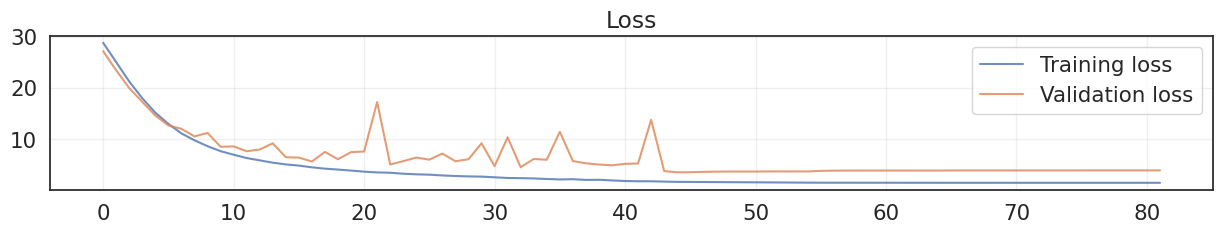

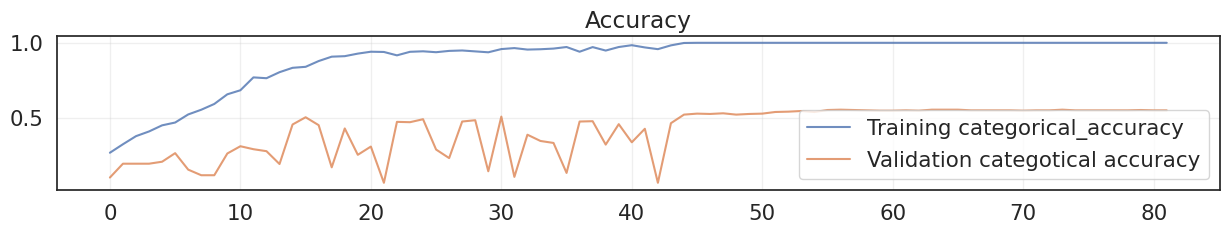

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['categorical_accuracy'], label='Training categorical_accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation categotical accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# as we can see it overfits a lot

In [ ]:
# prediction
model_nodule=model
preds_nodule = model_nodule.predict(X_val_nodule, verbose=0)
print("Predictions Shape:", preds_nodule.shape)

pred_classes_nodule = np.argmax(preds_nodule, axis=1) # not in one-hot
pred_classes_nodule = pred_classes_nodule + 1

print(preds_nodule[0])
print(pred_classes_nodule[0])
print(y_val_nodule[0])

Predictions Shape: (456, 5)
[0.15816304 0.19555087 0.63879275 0.00158823 0.00590508]
3
[0. 1. 0. 0. 0.]


Accuracy score over the test set: 0.5548
Precision score over the test set: 0.5366
Recall score over the test set: 0.5548
F1 score over the test set: 0.5366


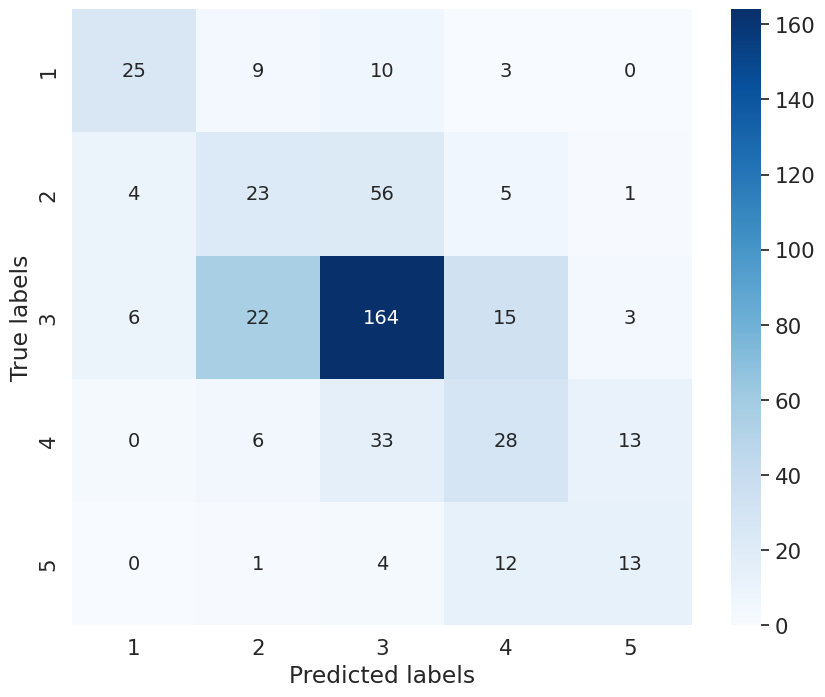

In [ ]:
# CONFUSION MATRIX
# Extract ground truth classes
true_classes = np.argmax(y_val_nodule, axis=-1)
true_classes = true_classes + 1

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

### 2.Only Radiomic features

Since the nodule images are a zoom on the nodule, we tried to extract the radiomic features from the nodule even if we didn't have the exact segmentation. This is the model trained using these features as input

In [ ]:
#One-Hot encoding of the labels
y_train_nodule = tfk.utils.to_categorical(y_train_nodule)
y_val_nodule = tfk.utils.to_categorical(y_val_nodule )

print(y_val_nodule.shape)
# ok, 5 classes (0-4 which corrispond to the real classes 1-5) => at the end I have to make +1 to the predictions

(456, 5)


In [ ]:
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from tensorflow.keras.regularizers import l2
def deep_model(num_features=train_features.shape[1], classes=5):
    # A. Wide features
    input_layer = Input(shape= (num_features, ), name = 'wide_features')

    # B. Hidden Layers with Batch Normalization and Dropout
    x = tfkl.Dense(128, kernel_regularizer=l2(0.001))(input_layer)
    x = tfkl.BatchNormalization()(x)  # Batch Normalization
    #x = tfkl.ReLU()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Dropout(0.3)(x)  # Dropout Layer

    skip = x
    x = tfkl.Dense(256, kernel_regularizer=l2(0.001))(x)
    if skip.shape[-1] != x.shape[-1]:
        skip = tfkl.Dense(x.shape[-1])(skip)
    x = tfkl.add([x, skip])
    x = tfkl.BatchNormalization()(x)
    #x = tfkl.ReLU()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Dropout(0.4)(x)

    skip_2=x
    x = tfkl.Dense(512, kernel_regularizer=l2(0.001))(x)
    if skip.shape[-1]!= x.shape[-1]:
        skip = tfkl. Dense(x.shape[-1])(skip)
    x = tfkl.add([x, skip])
    x = tfkl.BatchNormalization()(x)
    #x = tfkl.ReLU()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Dropout(0.5)(x)

    # C.Output layer
    output_layer = Dense(classes, activation='softmax', name='classifier')(x)
    model = Model(inputs=input_layer,outputs=output_layer)

    return model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ wide_features          │ (None, 18)           │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 128)          │        2,432 │ wide_features[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 128)          │          512 │ dense[0][0]         │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ leaky_re_lu            │ (None, 128)          │            0 │ batch_normalizatio… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout (Dropout)      │ (None, 128)          │            0 │ leaky_re_lu[0][0]   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_1 (Dense)        │ (None, 256)          │       33,024 │ dropout[0][0]       │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_2 (Dense)        │ (None, 256)          │       33,024 │ dropout[0][0]       │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 256)          │            0 │ dense_1[0][0],      │    -    │
│                        │                      │              │ dense_2[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 256)          │        1,024 │ add[0][0]           │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ leaky_re_lu_1          │ (None, 256)          │            0 │ batch_normalizatio… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dropout_1 (Dropout)    │ (None, 256)          │            0 │ leaky_re_lu_1[0][0] │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_3 (Dense)        │ (None, 512)          │      131,584 │ dropout_1[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_4 (Dense)        │ (None, 512)          │      131,584 │ dense_2[0][0]       │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add_1 (Add)            │ (None, 512)          │            0 │ dense_3[0][0],      │    -    │
│                        │                      │              │ dense_4[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 512)          │        2,048 │ add_1[0][0]         │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ leaky_re_lu_2        

 Total params: 337,797 (1.29 MB)

 Trainable params: 336,005 (1.28 MB)

 Non-trainable params: 1,792 (7.00 KB)

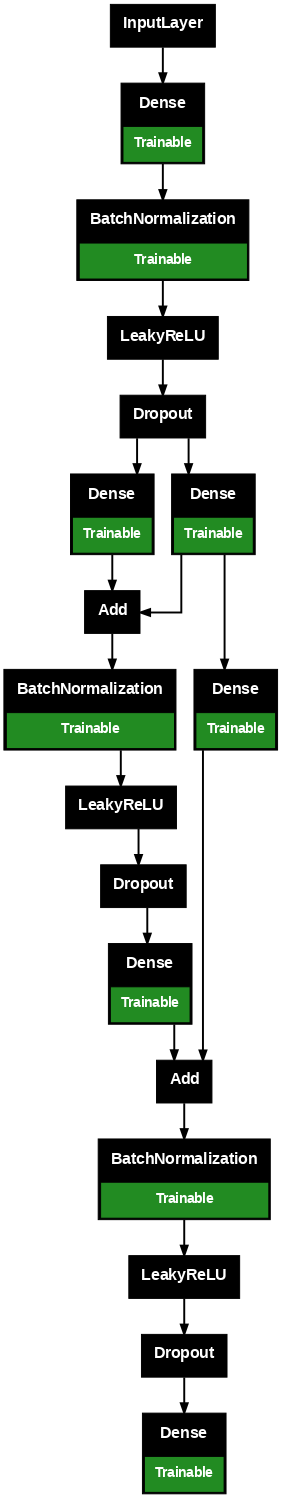

In [ ]:
# Build the model with specified input and output shapes
model_FFNN = deep_model()
model_FFNN.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model_FFNN, expand_nested=True, show_trainable=True,  dpi=70)

In [ ]:
Learning_rate=1e-3

model_FFNN.compile(
    optimizer = keras.optimizers.AdamW(Learning_rate),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
### Setup callbacks

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=1e-6)

In [ ]:
history = model_FFNN.fit(
    x=train_features,
    y=y_train_nodule,
    batch_size=128,
    epochs=1000,
    validation_data=(val_features, y_val_nodule),
    callbacks=[early_stopping, LR_schedule],
    class_weight=class_weights_nodule,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'features_'+str(final_val_accuracy)+'.keras'
model_FFNN.save(model_filename)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 321ms/step - Precision: 0.2767 - Recall: 0.1725 - accuracy: 0.2474 - loss: 2.5178 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1952 - val_loss: 2.1527 - learning_rate: 0.0010
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.3805 - Recall: 0.2600 - accuracy: 0.3562 - loss: 2.0789 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2412 - val_loss: 2.1291 - learning_rate: 0.0010
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4396 - Recall: 0.2925 - accuracy: 0.4162 - loss: 1.9247 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2434 - val_loss: 2.0837 - learning_rate: 0.0010
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.4288 - Recall: 0.2880 - accuracy: 0.4049 - loss: 1.8788 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2478 - val_loss: 2.0415 - learning_rate: 0.0010
Epoch 5/1000
15/15 ━━━━━━━━━━

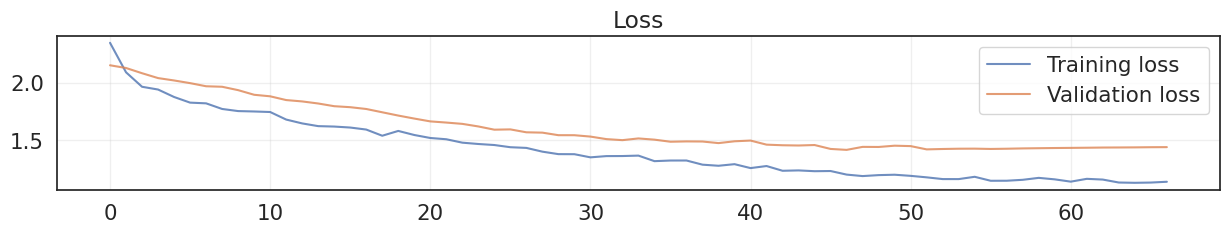

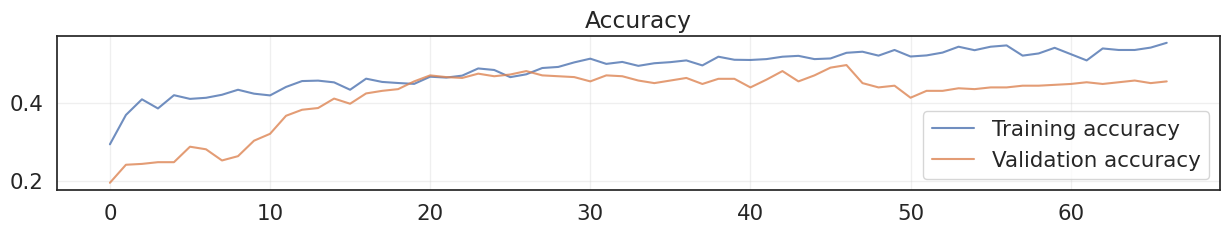

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# prediction
model_nodule=model_FFNN
preds_nodule = model_nodule.predict(val_features, verbose=0)
print("Predictions Shape:", preds_nodule.shape)

pred_classes_nodule = np.argmax(preds_nodule, axis=1)
pred_classes_nodule = pred_classes_nodule + 1

print(preds_nodule[0])
print(pred_classes_nodule[0])
print(y_val_nodule[0])

Predictions Shape: (456, 5)
[0.02167657 0.16113831 0.4066379  0.40494502 0.00560214]
3
[0. 1. 0. 0. 0.]


Accuracy score over the test set: 0.4956
Precision score over the test set: 0.5251
Recall score over the test set: 0.4956
F1 score over the test set: 0.4976


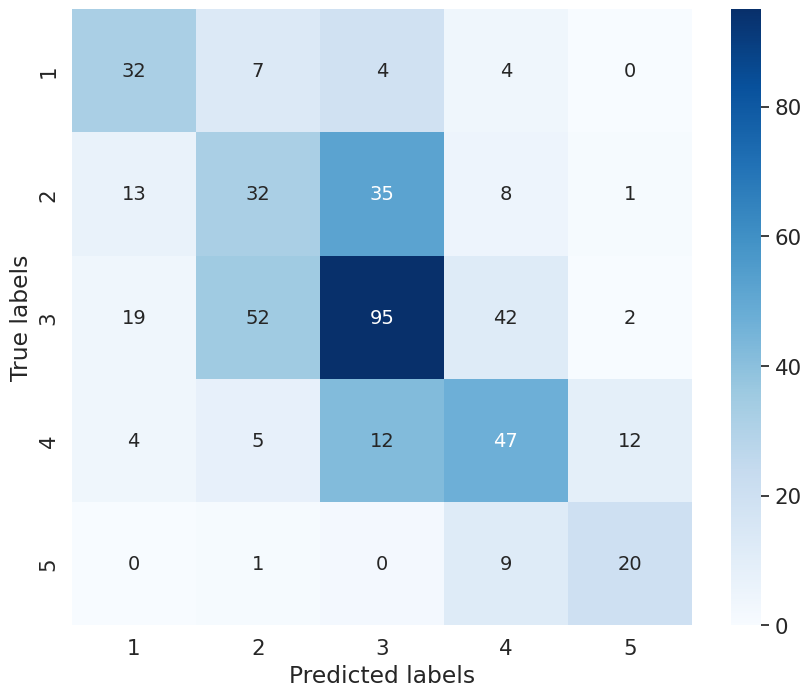

In [ ]:
# CONFUSION MATRIX
# Extract ground truth classes
true_classes = np.argmax(y_val_nodule, axis=-1)
true_classes = true_classes + 1

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

### 3.Radiomic Features + images

#### 3.1 Binary

First we trained the Binary model (Benign vs malign), and then we fine-tuned over the 5 classes.





In [ ]:
def se_block(x, reduction_ratio=16):
    # Ottieni le dimensioni dell'output
    filters = x.shape[-1]

    # "Squeeze" - ridurre la dimensione spaziale
    se = tfkl.GlobalAveragePooling2D()(x)

    # "Excite" - ridurre la dimensione dei canali
    se = tfkl.Dense(filters // reduction_ratio, activation='relu')(se)
    se = tfkl.Dense(filters, activation='sigmoid')(se)

    # Ridimensiona il vettore di attenzione
    se = tfkl.Reshape((1, 1, filters))(se)

    # Moltiplica il tensore di input per il tensore di attenzione
    x = tfkl.Multiply()([x, se])

    return x

In [ ]:
# Residual Block
def res_block(x, filters, kernel_size=3, stride=1):
    # Save the input for the residual connection
    skip = x

    # First convolution
    x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, kernel_regularizer=regularizers.l2(0.01),strides=stride, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    # Second convolution
    x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, kernel_regularizer=regularizers.l2(0.01),strides=1, padding='same')(x)
    x = tfkl.BatchNormalization()(x)

    # Convoluzione bottleneck finale (1x1)
    #x = tfkl.Conv2D(filters=filters, kernel_size=1, kernel_regularizer=regularizers.l2(0.01), strides=1, padding='same')(x)
    #x = tfkl.BatchNormalization()(x)

    # Allinea i canali di skip con i canali di x (se necessario) usando una convoluzione 1x1
    if skip.shape[-1] != x.shape[-1]:
        skip = tfkl.Conv2D(x.shape[-1], (1, 1), strides=stride, padding='same')(skip)
        #skip = tfkl.BatchNormalization()(skip)  # Normalizzazione anche sulla skip

    # Aggiungi la skip connection
    x = tfkl.add([x, skip])  # Residual connection
    x = tfkl.ReLU()(x)
    #x = se_block(x)
    return x

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, BatchNormalization, ReLU

def inception_block(x, filters):
    # Branch 1: 1x1 convolution
    branch_1 = Conv2D(filters, (1, 1), padding='same')(x)
    branch_1 = BatchNormalization()(branch_1)
    branch_1 = ReLU()(branch_1)

    # Branch 2: 1x1 convolution followed by 3x3 convolution
    branch_2 = Conv2D(filters, (1, 1), padding='same')(x)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = ReLU()(branch_2)
    branch_2 = Conv2D(filters, (3, 3), padding='same')(branch_2)
    branch_2 = BatchNormalization()(branch_2)
    branch_2 = ReLU()(branch_2)

    # Branch 3: 1x1 convolution followed by 5x5 convolution
    branch_3 = Conv2D(filters, (1, 1), padding='same')(x)
    branch_3 = BatchNormalization()(branch_3)
    branch_3 = ReLU()(branch_3)
    branch_3 = Conv2D(filters, (5, 5), padding='same')(branch_3)
    branch_3 = BatchNormalization()(branch_3)
    branch_3 = ReLU()(branch_3)

    # Branch 4: MaxPooling followed by 1x1 convolution
    branch_4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_4 = Conv2D(filters, (1, 1), padding='same')(branch_4)
    branch_4 = BatchNormalization()(branch_4)
    branch_4 = ReLU()(branch_4)

    # Concatenate all branches
    output = concatenate([branch_1, branch_2, branch_3, branch_4], axis=-1)

    return output


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LayerNormalization

seed=42
def build_model(
    input_shape=(64,64,1),
    output_shape=5,
    num_wide_features=train_features.shape[1],
    augmentation=augmentation,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # A. Wide features
    feature_input = Input(shape= (num_wide_features, ), name = 'feature_input')
    x_feature = Dense(128, kernel_regularizer=l2(0.001))(feature_input)
    x_feature = BatchNormalization()(x_feature)
    x_feature = Activation('relu')(x_feature)
    x_feature = tfkl.Dropout(0.3)(x_feature)

    skip = x_feature
    x_feature = Dense(256, kernel_regularizer=l2(0.001))(x_feature)
    if skip.shape[-1] != x_feature.shape[-1]:
        skip = tfkl.Dense(x_feature.shape[-1])(skip)
    x_feature = tfkl.add([x_feature, skip])
    x_feature = BatchNormalization()(x_feature)
    x_feature = Activation('relu')(x_feature)
    x_feature = tfkl.Dropout(0.4)(x_feature)

    x_feature = Dense(512, kernel_regularizer=l2(0.001))(x_feature)
    if skip.shape[-1]!= x_feature.shape[-1]:
        skip = tfkl. Dense(x_feature.shape[-1])(skip)
    x_feature = tfkl.add([x_feature, skip])
    x_feature = BatchNormalization()(x_feature)
    x_feature = Activation('relu')(x_feature)
    x_feature = tfkl.Dropout(0.5)(x_feature)

    # B. Images
    input_image = tfkl.Input(shape=input_shape, name='Input')
    # Apply augmentation
    input_image = augmentation(input_image)

    # first convolutional layer
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_image)
    x = tfkl.BatchNormalization(name='bn0')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp')(x)
    x = se_block(x)

    x=res_block(x,64)
    #x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_image)
    #x = tfkl.BatchNormalization(name='bn0')(x)  # Batch normalization
    #x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout1')(x)

    # second convolutional layer, activation, and pooling
    #x=res_block(x,128)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout2')(x)

    # third convolutional layer, activation, and pooling
    #x=res_block(x,256)
    x = inception_block(x, filters=256)
    x = tfkl.BatchNormalization(name='bn2')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.2, name='dropout3')(x)

    # fourth convolutional layer, activation, and pooling
    #x=res_block(x,512)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    x = se_block(x)

    # fourth convolutional layer, activation, and pooling
    x=res_block(x,1024)
    x = tfkl.MaxPooling2D(name='mp4')(x)
    x = se_block(x)
    #x = tfkl.Dropout(0.3, name='dropout5')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dense(128)(x)
    #x = tfkl.BatchNormalization(name='bn_dense')(x)  # Batch normalization
    x = tfkl.ReLU(name='relu_dense')(x)
    x = tfkl.Dropout(0.3)(x)

    x = tfkl.BatchNormalization(name='bn_x')(x)
    x_feature = tfkl.BatchNormalization(name='bn_x_feature')(x_feature)
    shared_path = concatenate([x, x_feature], name='concat_layer')
    shared_path = tfkl.BatchNormalization(name='bn_concatenation')(shared_path)
    shared_path = Dense(64)(shared_path)
    shared_path = Activation('relu')(shared_path)
    shared_path = tfkl.Dropout(0.4)(shared_path)
    shared_path = Dense(128)(shared_path)
    shared_path = Activation('relu')(shared_path)
    shared_path = tfkl.Dropout(0.5)(shared_path)
    #output_layer = Dense(output_shape, activation='softmax', name='output_layer')(shared_path)
    output_layer = Dense (1, activation='sigmoid', name='output_layer')(shared_path)

    # Finally the model is composed by connecting inputs to outputs:
    model = Model(inputs=[input_image,  feature_input], outputs=output_layer)

    # Return the compiled model
    return model

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ keras_tensor_45CLONE   │ (None, None, None,   │            0 │ -                   │    -    │
│ (InputLayer)           │ 1)                   │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv0 (Conv2D)         │ (None, None, None,   │          320 │ keras_tensor_45CLO… │    Y    │
│                        │ 32)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ bn0                    │ (None, None, None,   │          128 │ conv0[1][0]         │    Y    │
│ (BatchNormalization)   │ 32)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ relu0 (ReLU)           │ (None, None, None,   │            0 │ bn0[1][0]           │    -    │
│                        │ 32)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ mp (MaxPooling2D)      │ (None, None, None,   │            0 │ relu0[1][0]         │    -    │
│                        │ 32)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 32)           │            0 │ mp[1][0]            │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_10 (Dense)       │ (None, 2)            │           66 │ global_average_poo… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_11 (Dense)       │ (None, 32)           │           96 │ dense_10[1][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 32)     │            0 │ dense_11[1][0]      │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ multiply (Multiply)    │ (None, None, None,   │            0 │ mp[1][0],           │    -    │
│                        │ 32)                  │              │ reshape[1][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, None, None,   │       18,496 │ multiply[1][0]      │    Y    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_6  │ (None, None, None,   │          256 │ conv2d[1][0]        │    Y    │
│ (BatchNormalization)   │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ re_lu (ReLU)           │ (None, None, None,   │            0 │ batch_normalizatio… │    -    │
│                        │ 64)                  │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, None, None,   │       36,928 │ re_lu[1][0]         │    Y    │
│                        │ 64)                  │              │                     │         │
├──────────────────────

 Total params: 22,737,999 (86.74 MB)

 Trainable params: 22,722,831 (86.68 MB)

 Non-trainable params: 15,168 (59.25 KB)

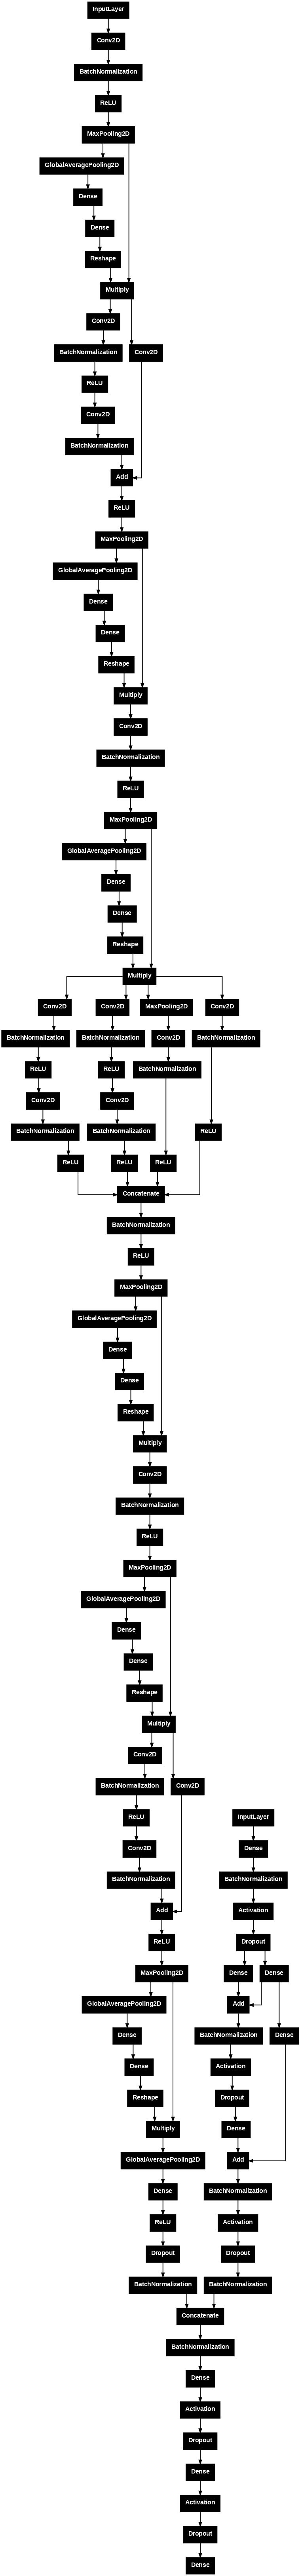

In [ ]:
# Build the model with specified input and output shapes
model_wide = build_model()

model_wide.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model_wide, expand_nested=True, dpi=70)# show_trainable=True,  dpi=70)

In [ ]:
learning_rate = 1e-4
model_wide.compile(
    optimizer = keras.optimizers.AdamW(learning_rate),
    #optimizer =keras.optimizers.SGD(),
    #loss = keras.losses.CategoricalCrossentropy(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
### Setup callbacks

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    min_delta=1e-6)

In [ ]:
#y_train_nodule_bin=tfk.utils.to_categorical(y_train_nodule_bin)
#y_val_nodule_bin=tfk.utils.to_categorical(y_val_nodule_bin)

In [ ]:
history = model_wide.fit(
    x=[X_train_nodule, train_features],
    y=y_train_nodule_bin,  # Etichette di training (one-hot encoded)
    batch_size=32,
    epochs=1000,
    validation_data=([X_val_nodule, val_features], y_val_nodule_bin),
    callbacks=[early_stopping, LR_schedule],
    class_weight=weights_nodule_bin, #class_weights_nodule,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename_1 = 'model_1_'+str(final_val_accuracy)+'.keras'
model_wide.save(model_filename_1)

Epoch 1/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 412ms/step - Precision: 0.2381 - Recall: 0.8166 - accuracy: 0.3585 - loss: 18.9276 - val_Precision: 0.8750 - val_Recall: 0.1909 - val_accuracy: 0.7982 - val_loss: 17.0471 - learning_rate: 1.0000e-04
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - Precision: 0.2725 - Recall: 0.7477 - accuracy: 0.4832 - loss: 16.5696 - val_Precision: 1.0000 - val_Recall: 0.0182 - val_accuracy: 0.7632 - val_loss: 15.0717 - learning_rate: 1.0000e-04
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - Precision: 0.3032 - Recall: 0.6645 - accuracy: 0.5736 - loss: 14.7813 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.7588 - val_loss: 13.4779 - learning_rate: 1.0000e-04
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - Precision: 0.3555 - Recall: 0.7039 - accuracy: 0.6409 - loss: 13.1827 - val_Precision: 0.8571 - val_Recall: 0.0545 - val_accuracy: 0.7697 - val_loss: 12.0499 - learning_rate: 1.0000e-04
Epoch 5/1000
57/57 ━━━━━━━

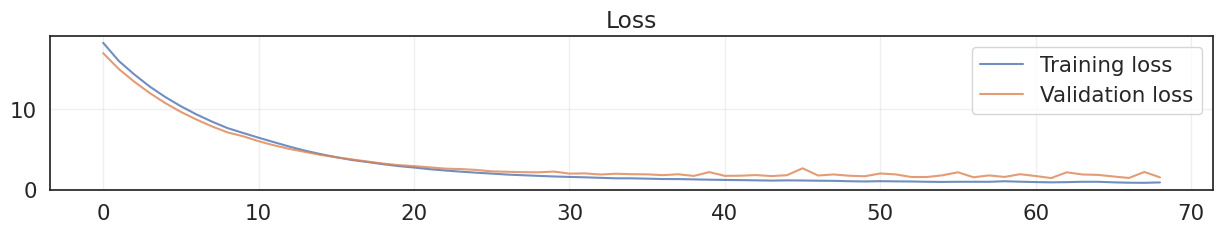

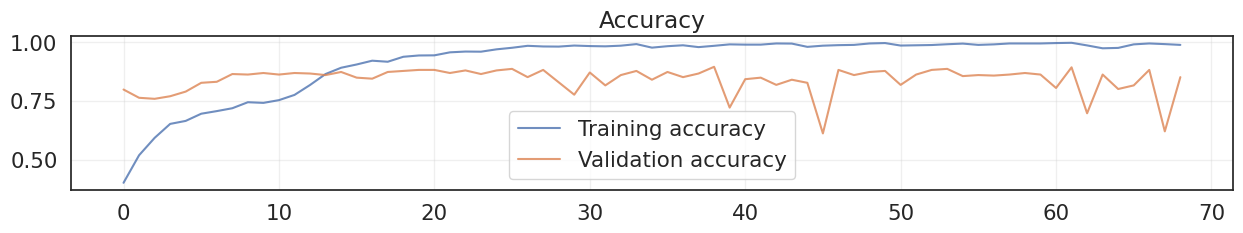

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
from tensorflow import keras as keras

model_nodule=model_wide
preds_nodule = model_nodule.predict([X_val_nodule, val_features], verbose=0)
print("Predictions Shape:", preds_nodule.shape)
pred_classes_nodule = (preds_nodule >= 0.5).astype(int)
#pred_classes_nodule = np.argmax(preds_nodule, axis=1) # not in one-hot
#pred_classes_nodule = pred_classes_nodule + 1

print(preds_nodule[5])
print(pred_classes_nodule[5])
print(y_val_nodule_bin[5])
print(y_val_nodule[5])

Predictions Shape: (456, 1)
[6.8166395e-05]
[0]
0
[0. 0. 1. 0. 0.]


Accuracy score over the test set: 0.8947
Precision score over the test set: 0.8925
Recall score over the test set: 0.8947
F1 score over the test set: 0.8901


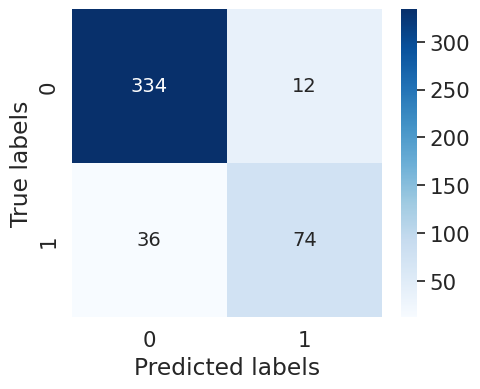

In [ ]:
# Extract ground truth classes
#true_classes = np.argmax(y_val_nodule, axis=-1)
#true_classes = true_classes + 1
true_classes=y_val_nodule_bin

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=[0,1], yticklabels=[0,1], cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

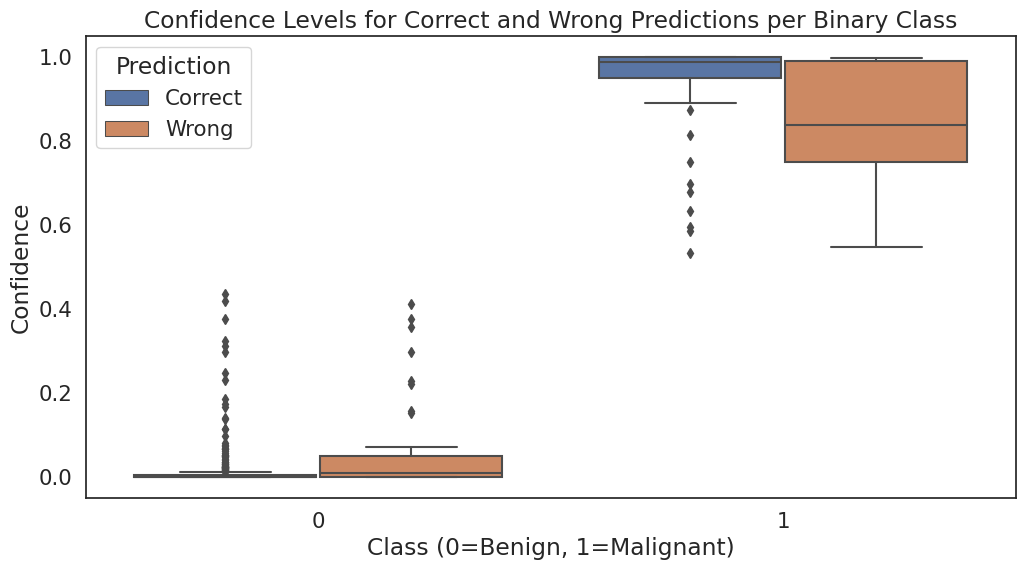

In [ ]:
boxplot_data = []

# Itera sulle due classi binarie: 0 (benigno) e 1 (maligno)
for class_label in [0, 1]:  # 0 per benigno, 1 per maligno
    # Trova gli indici dove la predizione è la classe attuale (class_label)
    class_indices = np.where(pred_classes_nodule == class_label)[0]

    # Per ogni predizione, ottieni la confidenza (probabilità della classe predetta)
    conf_class = preds[class_indices, 0]  # Poiché preds ha una sola colonna, prendi il primo (e unico) valore

    # Determina la classe predetta (0 o 1) basata sulla soglia 0.5
    predicted_class = (conf_class >= 0.5).astype(int)

    # Verifica se la predizione è corretta
    true_class = (predicted_class == true_classes[class_indices])

    # Dividi le confidenze in giuste (predicted_class == true_class) e sbagliate
    correct_conf = conf_class[true_class]
    wrong_conf = conf_class[~true_class]

    # Aggiungi i dati nel DataFrame
    for conf_data, label in zip([correct_conf, wrong_conf], ['Correct', 'Wrong']):
        if len(conf_data) > 0:  # Controlla che ci siano dati
            df = pd.DataFrame({
                'Confidence': conf_data,
                'Prediction': [label] * len(conf_data),
                'Class': [class_label] * len(conf_data)
            })
            boxplot_data.append(df)

# Concateniamo i dati in un unico DataFrame
plot_df = pd.concat(boxplot_data)

# Creiamo il boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Confidence', hue='Prediction', data=plot_df)
plt.title('Confidence Levels for Correct and Wrong Predictions per Binary Class')
plt.ylabel('Confidence')
plt.xlabel('Class (0=Benign, 1=Malignant)')
plt.show()

# as we can see the confidence is better for the correct predictions.
# indeed, ideally the instances belonging to class 0 should have a 0 value as ouput of the sigmoid
# and, as opposite, the instances belonging to class 1 should have 1.
# So, if the output of the sigmoid is more nearer the 0.5 it means that the model is more uncertaint.

#### 3.2 5-classes

Now we fine-tune the model over the five classes

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_45CLONE      │ (None, None, None, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, None, None, 64) │            640 │ keras_tensor_45CLONE[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, None, None, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (ReLU)              │ (None, None, None, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp0 (MaxPooling2D)        │ (None, None, None, 64) │              0 │ relu0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ mp0[0][0]              │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │            320 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, None, None, 64) │              0 │ mp0[0][0],             │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, None, None,     │         73,856 │ multiply[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, None, None,     │            512 │ conv1[0][0]            │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu1 (ReLU)              │ (None, None, None,     │              0 │ bn1[0][0]              │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mp1 (MaxPooling2D)        │ (None, None, None,     │              0 │ relu1[0][0]            │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ mp1[0][0]              │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)     

 Total params: 22,680,753 (86.52 MB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 22,629,484 (86.32 MB)

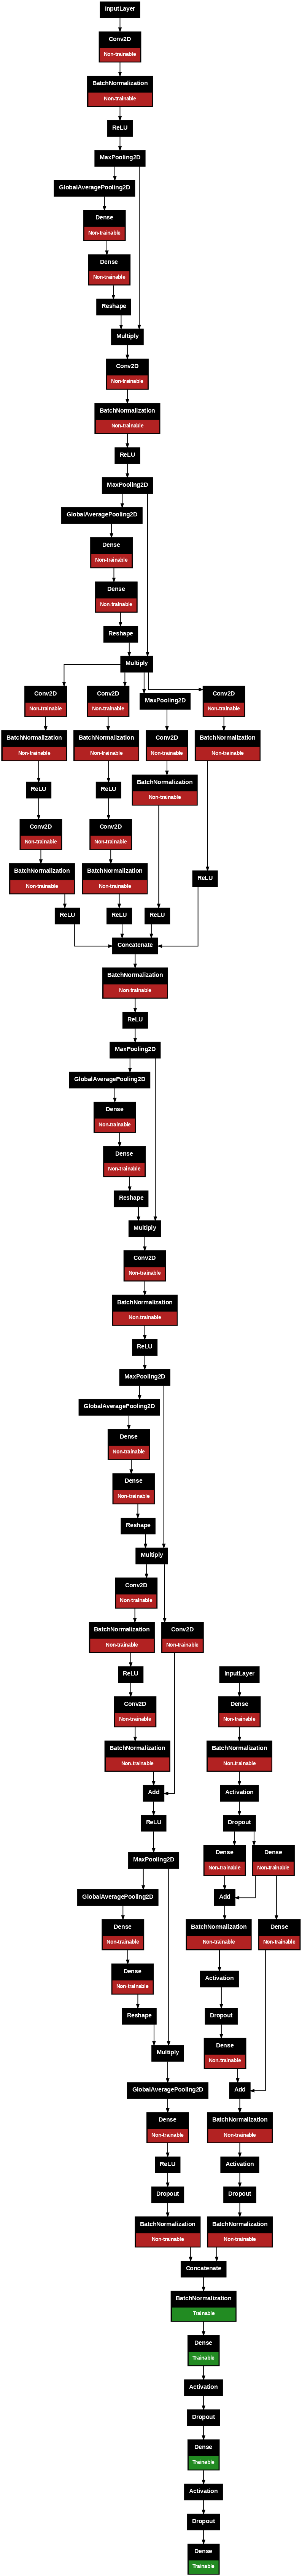

In [ ]:
model_wide=keras.models.load_model(model_filename_1)
model_wide.layers.pop()
x = model_wide.layers[-2].output  # Prendi l'output del penultimo layer
new_output_layer = Dense(5, activation='softmax', name='output_layer_5')(x) # new output layer

freeze_until = -8
for layer in model_wide.layers[:freeze_until]:
    layer.trainable = False
for layer in model_wide.layers[freeze_until:]:
    layer.trainable = True

model_wide = Model(inputs=model_wide.inputs, outputs=new_output_layer)
model_wide.summary()

# Plot the model architecture
tfk.utils.plot_model(model_wide, expand_nested=True, show_trainable=True,  dpi=70)

In [ ]:
learning_rate = 1e-4
model_wide.compile(
    optimizer = keras.optimizers.AdamW(learning_rate),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
### Setup callbacks

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=25,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
    min_delta=1e-6)

In [ ]:
history = model_wide.fit(
    x=[X_train_nodule, train_features],
    y=y_train_nodule,  # Etichette di training (one-hot encoded)
    batch_size=32,
    epochs=1000,
    validation_data=([X_val_nodule, val_features], y_val_nodule),
    callbacks=[early_stopping, LR_schedule],
    class_weight=class_weights_nodule,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename_2 = 'model_2_'+str(final_val_accuracy)+'.keras'
model_wide.save(model_filename_2)

Epoch 1/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - Precision: 0.2976 - Recall: 0.1715 - accuracy: 0.2805 - loss: 2.6966 - val_Precision: 0.6607 - val_Recall: 0.1623 - val_accuracy: 0.4934 - val_loss: 1.4099 - learning_rate: 1.0000e-04
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Precision: 0.4564 - Recall: 0.2780 - accuracy: 0.4072 - loss: 2.0519 - val_Precision: 0.6550 - val_Recall: 0.2873 - val_accuracy: 0.5439 - val_loss: 1.3127 - learning_rate: 1.0000e-04
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Precision: 0.6426 - Recall: 0.4171 - accuracy: 0.5573 - loss: 1.4844 - val_Precision: 0.6120 - val_Recall: 0.3355 - val_accuracy: 0.5592 - val_loss: 1.2987 - learning_rate: 1.0000e-04
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - Precision: 0.6532 - Recall: 0.4563 - accuracy: 0.5904 - loss: 1.3372 - val_Precision: 0.6103 - val_Recall: 0.3882 - val_accuracy: 0.5636 - val_loss: 1.3230 - learning_rate: 1.0000e-04
Epoch 5/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
from tensorflow import keras as keras

model_nodule=model_wide
preds_nodule = model_nodule.predict([X_val_nodule, val_features], verbose=0)
print("Predictions Shape:", preds_nodule.shape)

pred_classes_nodule = np.argmax(preds_nodule, axis=1) # not in one-hot
pred_classes_nodule = pred_classes_nodule + 1

print(preds_nodule[0])
print(pred_classes_nodule[0])
print(y_val_nodule[0])

Predictions Shape: (456, 5)
[0.30405197 0.28623238 0.2312282  0.08575081 0.09273674]
1
[0. 1. 0. 0. 0.]


Accuracy score over the test set: 0.5943
Precision score over the test set: 0.5969
Recall score over the test set: 0.5943
F1 score over the test set: 0.5536


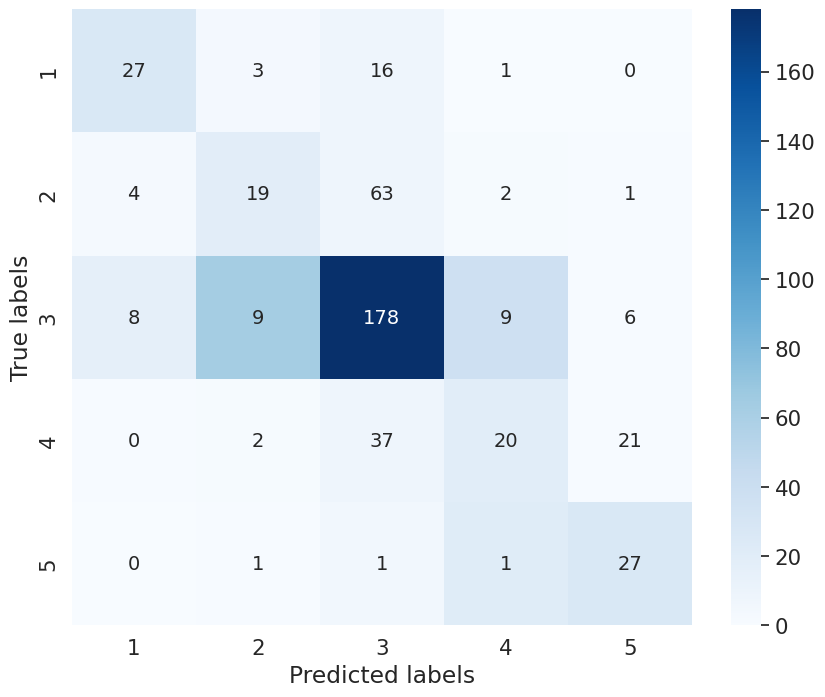

In [ ]:
# Extract ground truth classes
true_classes = np.argmax(y_val_nodule, axis=-1)
true_classes = true_classes + 1

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

Now we train some more layers

In [ ]:
model_wide=keras.models.load_model(model_filename_2)
unfreeze_until = -8
for layer in model_wide.layers[:unfreeze_until]:
    layer.trainable = True
for layer in model_wide.layers[unfreeze_until:]:
    layer.trainable = False

# Plot the model architecture
#tfk.utils.plot_model(model_wide, expand_nested=True, dpi=70) #show_trainable=True,  dpi=70)

In [ ]:
learning_rate = 1e-4
model_wide.compile(
    optimizer = keras.optimizers.AdamW(learning_rate),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
### Setup callbacks

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=22,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=1e-6)

In [ ]:
history = model_wide.fit(
    x=[X_train_nodule, train_features],
    y=y_train_nodule,  # Etichette di training (one-hot encoded)
    batch_size=32,
    epochs=1000,
    validation_data=([X_val_nodule, val_features], y_val_nodule),
    callbacks=[early_stopping, LR_schedule],
    class_weight=class_weights_nodule,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename_3 = 'model_3_'+str(final_val_accuracy)+'.keras'
model_wide.save(model_filename_3)

Epoch 1/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - Precision: 0.7172 - Recall: 0.5868 - accuracy: 0.6538 - loss: 1.6370 - val_Precision: 0.3086 - val_Recall: 0.1732 - val_accuracy: 0.2368 - val_loss: 2.5992 - learning_rate: 1.0000e-04
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - Precision: 0.6240 - Recall: 0.4947 - accuracy: 0.5746 - loss: 2.1436 - val_Precision: 0.5954 - val_Recall: 0.2259 - val_accuracy: 0.4276 - val_loss: 2.1167 - learning_rate: 1.0000e-04
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - Precision: 0.6619 - Recall: 0.5095 - accuracy: 0.5989 - loss: 1.8016 - val_Precision: 0.2027 - val_Recall: 0.1952 - val_accuracy: 0.2018 - val_loss: 5.0707 - learning_rate: 1.0000e-04
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - Precision: 0.5873 - Recall: 0.4890 - accuracy: 0.5487 - loss: 2.6023 - val_Precision: 0.3817 - val_Recall: 0.3289 - val_accuracy: 0.3706 - val_loss: 3.4269 - learning_rate: 1.0000e-04
Epoch 5/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s

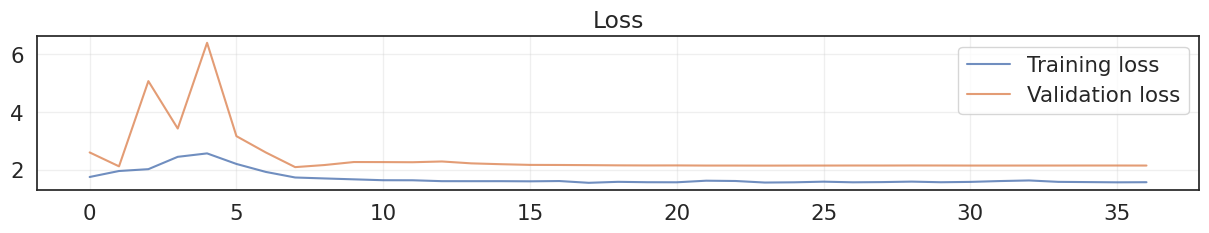

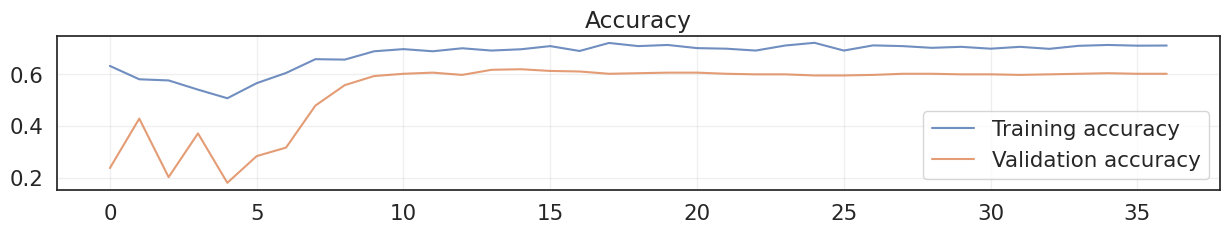

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
from tensorflow import keras as keras

model_nodule=model_wide
preds_nodule = model_nodule.predict([X_val_nodule, val_features], verbose=0)
print("Predictions Shape:", preds_nodule.shape)

pred_classes_nodule = np.argmax(preds_nodule, axis=1) # not in one-hot
pred_classes_nodule = pred_classes_nodule + 1

print(preds_nodule[0])
print(pred_classes_nodule[0])
print(y_val_nodule[0])

Predictions Shape: (456, 5)
[0.07053269 0.0365391  0.82534367 0.02809578 0.03948879]
3
[0. 1. 0. 0. 0.]


Accuracy score over the test set: 0.6184
Precision score over the test set: 0.6197
Recall score over the test set: 0.6184
F1 score over the test set: 0.5895


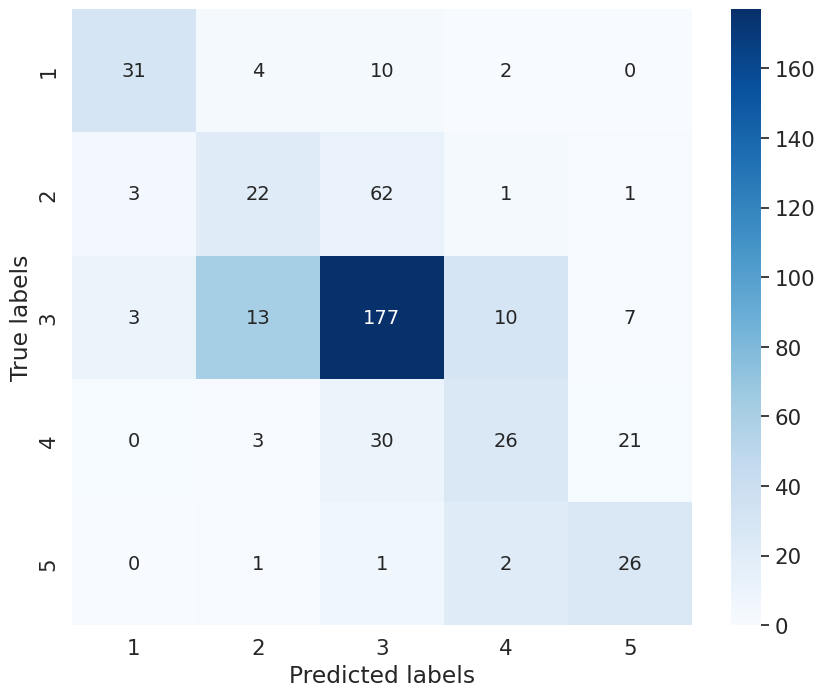

In [ ]:
# Extract ground truth classes
true_classes = np.argmax(y_val_nodule, axis=-1)
true_classes = true_classes + 1

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

Now we try to train all the layers

In [ ]:
model_wide=keras.models.load_model(model_filename_3)
for layer in model_wide.layers:
    layer.trainable = True

# Plot the model architecture
#tfk.utils.plot_model(model_wide, expand_nested=True, dpi=70) #show_trainable=True,  dpi=70)


In [ ]:
learning_rate = 1e-5  #decrease the LR
model_wide.compile(
    optimizer = keras.optimizers.AdamW(learning_rate),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
### Setup callbacks

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=25,
    restore_best_weights=True
)

# LR_schedule
LR_schedule = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
    min_delta=1e-6)

In [ ]:
history = model_wide.fit(
    x=[X_train_nodule, train_features],
    y=y_train_nodule,  # Etichette di training (one-hot encoded)
    batch_size=32,
    epochs=1000,
    validation_data=([X_val_nodule, val_features], y_val_nodule),
    callbacks=[early_stopping, LR_schedule],
    class_weight=class_weights_nodule,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename_4 = 'model_4_'+str(final_val_accuracy)+'.keras'
model_wide.save(model_filename_4)

Epoch 1/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 334ms/step - Precision: 0.7431 - Recall: 0.6117 - accuracy: 0.6852 - loss: 1.6385 - val_Precision: 0.6201 - val_Recall: 0.4868 - val_accuracy: 0.5965 - val_loss: 2.2773 - learning_rate: 1.0000e-05
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - Precision: 0.7651 - Recall: 0.6401 - accuracy: 0.7149 - loss: 1.5167 - val_Precision: 0.6288 - val_Recall: 0.4978 - val_accuracy: 0.5899 - val_loss: 2.2603 - learning_rate: 1.0000e-05
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - Precision: 0.7598 - Recall: 0.6452 - accuracy: 0.7208 - loss: 1.5174 - val_Precision: 0.6276 - val_Recall: 0.5285 - val_accuracy: 0.5943 - val_loss: 2.3815 - learning_rate: 1.0000e-05
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - Precision: 0.7609 - Recall: 0.6234 - accuracy: 0.7069 - loss: 1.5100 - val_Precision: 0.6138 - val_Recall: 0.5088 - val_accuracy: 0.5899 - val_loss: 2.4568 - learning_rate: 1.0000e-05
Epoch 5/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s

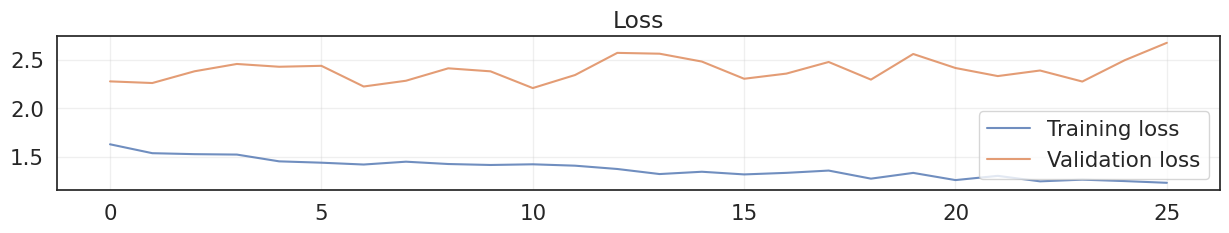

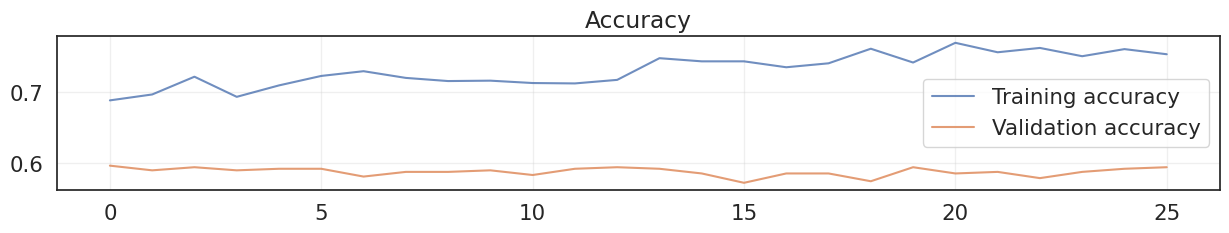

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
from tensorflow import keras as keras

model_nodule=model_wide
preds_nodule = model_nodule.predict([X_val_nodule, val_features], verbose=0)
print("Predictions Shape:", preds_nodule.shape)

pred_classes_nodule = np.argmax(preds_nodule, axis=1) # not in one-hot
pred_classes_nodule = pred_classes_nodule + 1

print(preds_nodule[0])
print(pred_classes_nodule[0])
print(y_val_nodule[0])

Predictions Shape: (456, 5)
[0.02599552 0.0133713  0.93337065 0.01200546 0.01525708]
3
[0. 1. 0. 0. 0.]


Accuracy score over the test set: 0.5965
Precision score over the test set: 0.5931
Recall score over the test set: 0.5965
F1 score over the test set: 0.5476


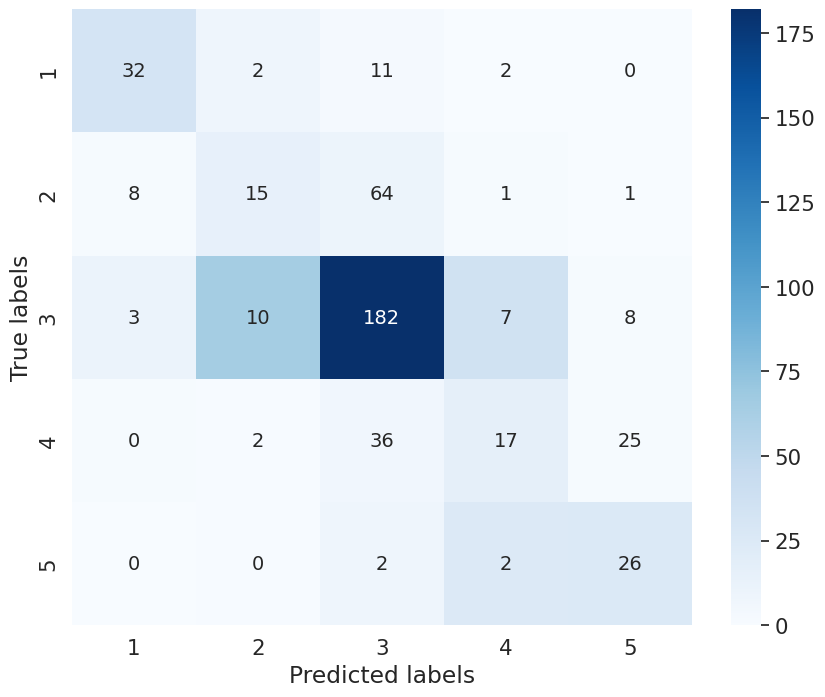

In [ ]:
# Extract ground truth classes
true_classes = np.argmax(y_val_nodule, axis=-1)
true_classes = true_classes + 1

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes_nodule)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes_nodule, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes_nodule, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes_nodule)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

labels={1,2,3,4,5}
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

As we can see, the performance are very similar between the models with all the layer freezed,some layers freezed or no layer freezed.

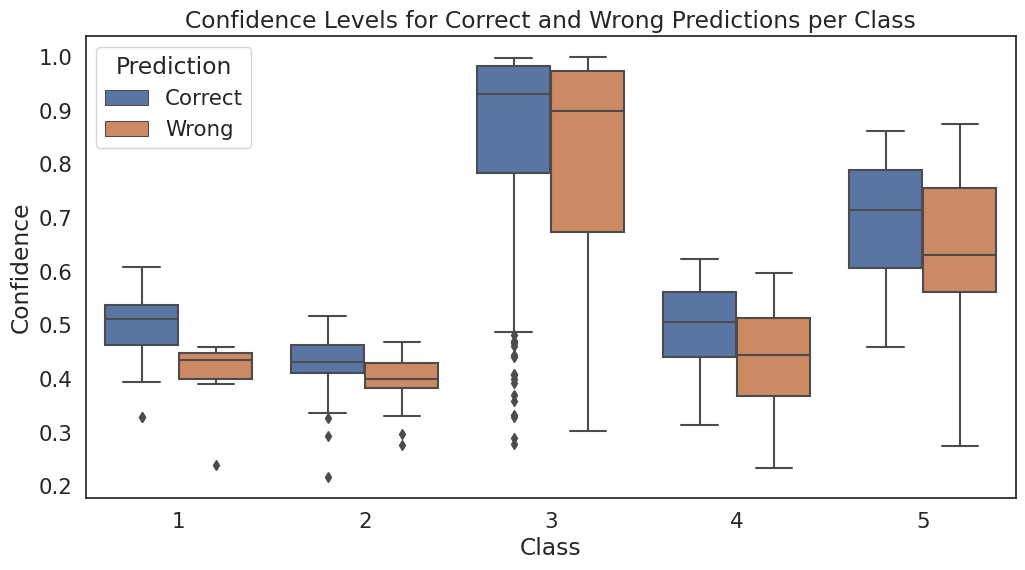

In [ ]:
boxplot_data = []
for class_label in range(1, 6):
    # Trova gli indici dove la predizione è la classe attuale (class_label)
    class_indices = np.where(pred_classes_nodule == class_label)[0]

    # Per ogni predizione, ottieni la confidenza (probabilità della classe predetta)
    conf_class = preds[class_indices, class_label - 1]

    # Dividi in giuste (y_pred == y_true) e sbagliate (y_pred != y_true)
    true_class = (pred_classes_nodule[class_indices] == true_classes[class_indices])

    # Salva i dati in un DataFrame per ciascuna classe e separa giuste/sbagliate
    for label, is_correct in zip(['Correct', 'Wrong'], [True, False]):
        conf_group = conf_class[true_class == is_correct]
        df = pd.DataFrame({
            'Confidence': conf_group,
            'Prediction': [label] * len(conf_group),
            'Class': [class_label] * len(conf_group)
        })
        boxplot_data.append(df)

# Concateniamo i dati in un unico DataFrame
plot_df = pd.concat(boxplot_data)

# Creiamo il boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Confidence', hue='Prediction', data=plot_df)
plt.title('Confidence Levels for Correct and Wrong Predictions per Class')
plt.ylabel('Confidence')
plt.xlabel('Class')
plt.show()

# as we can see correct predictions have higher confidence